In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import warnings
import random
import os

from datetime import timedelta
from statsmodels.tsa.api import VAR

# Set random seeds for reproducibility.
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
# Ignore warnings.
warnings.filterwarnings('ignore')

## <a style="color:purple;">**Analysis of the US Economy**</a> - part 3

#### Author: @**engine**, Date: December 2024, Deep Learning project

#### Abstract:
In the third part of this study, we answer the questions: what are the prospects for the US economy and under what conditions would the debt-to-GDP ratio reach 175%. This percentage is considered a critical point beyond which the sustainability of the economy is already in question. Several additional trends are also outlined, relevant conclusions are drawn.

### 1. **Introduction**

This study is a continuation of the previous two. The latter predicted the likelihood of a recession and indicated why one might not be declared. From here we ask ourselves the next logical question: can we measure the resilience of the US economy? And how? And also, how does US debt fit into all these processes of economic sustainability?

On the site **[Sustainable Economic Indicators](https://www.sustainable-environment.org.uk/Indicators/Economy.php)** we read:<br>
**Total GDP** and **GDP per capita** are good indicators of the relative strengths of the worlds nations.
Other indicators may include:

 - Investment in public, business and private assets (headline);
 - Social investment;
 - Rate of inflation;
 - Government borrowing and debt;
 - Competitiveness/productivity;
 - Trade/exports/imports.

However, it is increasingly being recognised these traditional economic indicators alone do not provide an adequate measure of an economy’s sustainability. To improve upon these indicators, we need to know how resource efficient our economy is, both in terms of the natural resources that it consumes (and wastes) and its utilisation of labour capital. Some indicators that have been proposed by the Government in this respect include:

 - Waste production, and energy and water consumption;
 - Transport indicators;
 - Education and employment;
 - Consumer expenditure;
 - Environmental management and reporting. [1]

This study **<a style="color:purple;">cannot cover all aspects of the sustainability of an economy</a>**, from internal social contradictions... to the state of the environment (ecology). But we **can safely use the most important indicators, which we can put into numbers** and then with **AI models**:

- **GROSS DOMESTIC PRODUCT** (**<a style="color:purple;">GDP</a>**) => Competitiveness/productivity;
- **Real GDP per capita** (A939RX0Q048SBEA) => Competitiveness/productivity;
- **Total Public Debt as Percent of GDP** (GFDEGDQ188S) => Competitiveness/productivity;<br>

- **Consumer Price Index** (CPI) => Consumer expenditure;
- **Industrial Production Index** (INDPRO) => Competitiveness/productivity;
- **S&P 500 Index** (SP500) => Investment in public, business and private assets;
- **Total Nonfarm Payroll** (PAYEMS) => Competitiveness/productivity (jobs);
- **Unemployment** (UNRATE) => Education and employment;
- **Federal Funds Effective Rate** (FEDFUNDS) => Rate of inflation;
- **Federal Debt: Total Public Debt** (GFDEBTN) => Government borrowing and debt;
- **Personal Saving Rate** (PSAVERT) => Social investment;
- **Trade Balance: Goods and Services, Balance of Payments Basis** (BOPGSTB) => Trade/exports/imports;
- **Total Debt Securities; Liability** (ASTDSL) => Government borrowing and debt;
- Federal government current expenditures: **Interest payments** (A091RC1Q027SBEA) =>  Government borrowing and debt;
- **Federal government current tax receipts** (W006RC1Q027SBEA) => Competitiveness/productivity;
- **Slope of the yield curve** (T10YFF) => Government borrowing and debt;
- **Federal Government: Current Expenditures** (FGEXPND) => Social investment;

For some of the data we will be able to easily interpolate back in time. Some of the data that we can include are not freely available, and others are either abandoned for collection back in time, or are being collected recently. **Back in time**, in the general case, we get a practical limit from **January 1966**, and for the moment we only have a limited amount of this data, which is published quarter by quarter. And with a great delay.

### 2. **Collection of economic indicators**

#### 2.1 **GROSS DOMESTIC PRODUCT** (GDP)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/GDP)** we only download information for the period of our study: **<a style="color:purple;">Gross Domestic Product (GDP)</a>**. [2] Units: **Billions of Dollars**, Seasonally Adjusted. Frequency: Quarterly.

In [5]:
gdp = pd.read_csv('data/GDP.csv') # Read the CSV file.
gdp.columns = ["date", "gdp"]
gdp['gdp'] = gdp['gdp'] * 1_000_000_000 # Convert to dollars.

Data for the period under study are given by **quartals**, not by months. To obtain all the requested data from **01.1962** to **the end of the study period**, we use a **linear approximation**.

In [7]:
gdp['date'] = pd.to_datetime(gdp['date'])
gdp_approx = gdp.copy()

# Create a new DataFrame with all dates from 1966-01-01 to end of period: 2025-03-01.
# Latest real data: 2025-01-01.
all_dates = pd.date_range(start='1966-01-01', end='2025-03-01', freq='MS')
gdp_all_dates = pd.DataFrame({'date': all_dates})

# Merge the two DataFrames and interpolate.
gdp_approx = pd.merge(gdp_all_dates, gdp, on='date', how='left')

# Linear interpolation for existing data.
gdp_approx['gdp'] = gdp_approx['gdp'].interpolate(method='linear')

# Find the last real date and extrapolate beyond it.
last_real_date = gdp['date'].max()
extrapolation_mask = gdp_approx['date'] > last_real_date

if extrapolation_mask.any():
    # Calculate average monthly change from last 12 months.
    last_12_months = gdp_approx[gdp_approx['date'] <= last_real_date].tail(12)
    monthly_changes = last_12_months['gdp'].diff().dropna()
    avg_monthly_change = monthly_changes.mean()
    
    # Get the last real value.
    last_real_value = gdp_approx[gdp_approx['date'] <= last_real_date]['gdp'].iloc[-1]
    
    # Extrapolate for future dates.
    future_indices = gdp_approx[extrapolation_mask].index
    for i, idx in enumerate(future_indices):
        gdp_approx.loc[idx, 'gdp'] = last_real_value + avg_monthly_change * (i + 1)

# Remove the 'year' and 'month' columns.
if 'year' in gdp_approx.columns:
    gdp_approx = gdp_approx.drop(columns=['year'])
if 'month' in gdp_approx.columns:
    gdp_approx = gdp_approx.drop(columns=['month'])

del gdp
gdp_approx.tail()

,date,gdp
706,2024-11-01,2.980812e+13
707,2024-12-01,2.989238e+13
708,2025-01-01,2.997664e+13
709,2025-02-01,3.008770e+13
710,2025-03-01,3.019876e+13


#### 2.2 **CONSUMER PRICE INDEX** (CPI)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/CPIAUCSL)** we only download information for the period of our study: **<a style="color:purple;">Consumer Price Index (CPI)</a>** for All Urban Consumers, All Items in U.S. City Average (CPIAUCSL). [3] Units: **Index**, Seasonally Adjusted. Frequency: Monthly.

In [9]:
cpi = pd.read_csv('data/CPIAUCSL.csv') # Read the CSV file.
cpi.columns = ["date", "cpi"]
cpi.tail()

,date,cpi
706,2024-11-01,316.449
707,2024-12-01,317.603
708,2025-01-01,319.086
709,2025-02-01,319.775
710,2025-03-01,319.615


#### 2.3 **Industrial Production Index** (INDPRO)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/INDPRO)** we download information for the period of our study: **<a style="color:purple;">Industrial Production Index (INDPRO)</a>** [4], Seasonally Adjusted. Frequency: Monthly.

In [11]:
indpro = pd.read_csv('data/INDPRO.csv') # Read the CSV file.
indpro.columns = ["date", "indpro"]
indpro.tail()

,date,indpro
706,2024-11-01,101.9503
707,2024-12-01,103.0723
708,2025-01-01,103.2131
709,2025-02-01,104.1490
710,2025-03-01,103.8865


#### 2.4 **S&P 500 Index** (SP500)

From this site **[Stooq](https://stooq.com/q/d/?s=%5Espx&c=0&d1=19620101&d2=20241001&i=m)** we download information for the period of our study: **<a style="color:purple;">S&P 500 Index (SP500)</a>** [5], Frequency: Monthly. This is the only publicly available data for the S&P 500 Index, which contains information all the way back to 1962!

In [13]:
sp = pd.read_csv('data/SP500.csv') # Read the CSV file.
# Keep only the required columns.
keep_col = ['Date', 'Close']
sp500 = sp[keep_col]
del sp
# Renaming columns.
sp500.columns = ['date', 'sp500']
sp500.tail()

,date,sp500
706,2024-11-30,6032.38
707,2024-12-31,5881.63
708,2025-01-31,6040.53
709,2025-02-28,5954.50
710,2025-03-31,5611.85


#### 2.5 **Total Nonfarm Payroll** (PAYEMS)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/PAYEMS)** we download information for the period of our study: **<a style="color:purple;">Total Nonfarm Payroll (PAYEMS)</a>** [6], Units: **Thousands of Persons**, Seasonally Adjusted. Frequency: Monthly.

In [15]:
payems = pd.read_csv('data/PAYEMS.csv') # Read the CSV file.
payems.columns = ["date", "payems"]
payems.tail()

,date,payems
706,2024-11-01,158619
707,2024-12-01,158942
708,2025-01-01,159053
709,2025-02-01,159155
710,2025-03-01,159275


#### 2.6 **UNEMPLOYMENT** (UNRATE)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/UNRATE)** we only download information for the period of our study: **<a style="color:purple;">Monthly Unemployment Rate (UNRATE)</a>**. [7] Units: **Percent**</a>, Seasonally Adjusted. Frequency: Monthly. 

In [17]:
unrate = pd.read_csv('data/UNRATE.csv') # Read the CSV file.
unrate.columns = ["date", "unrate"]
unrate["unrate"] = unrate["unrate"] / 100 # To get in percentages.
unrate.tail()

,date,unrate
706,2024-11-01,0.042
707,2024-12-01,0.041
708,2025-01-01,0.040
709,2025-02-01,0.041
710,2025-03-01,0.042


#### 2.7 **Federal Funds Effective Rate** (FEDFUNDS)

From this site **[Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/FEDFUNDS)** we only download information for the period of our study: **<a style="color:purple;">Federal Funds Effective Rate (FEDFUNDS)</a>**, Units: **Percent**. Frequency: Monthly [8]

In [19]:
fedfunds = pd.read_csv('data/FEDFUNDS.csv') # Read the CSV file.
fedfunds.columns = ["date", "fedfunds"]
fedfunds["fedfunds"] = fedfunds["fedfunds"] / 100 # To get in percentages.
fedfunds.tail()

,date,fedfunds
706,2024-11-01,0.0464
707,2024-12-01,0.0448
708,2025-01-01,0.0433
709,2025-02-01,0.0433
710,2025-03-01,0.0433


#### 2.8 **Total Public Debt** (GFDEBTN)

From this site **[Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/GFDEBTN)** we only download information for the period of our study: **<a style="color:purple;">Federal Debt: Total Public Debt (GFDEBTN)</a>**, Units: **Millions of Dollars**, Not Seasonally Adjusted. Frequency: Quarterly [9]

In [21]:
debt = pd.read_csv('data/GFDEBTN.csv') # Loading data.
debt.columns = ["date", "debt"]
debt['debt'] = debt['debt'] * 1_000_000 # Convert to dollars.

# Convert column 'date' to datetime.
debt['date'] = pd.to_datetime(debt['date'])

# Create a new DataFrame with all dates from 1966-01-01 to the end of the period.
all_dates = pd.date_range(start='1966-01-01', end='2025-03-01', freq='MS')
debt_all_dates = pd.DataFrame({'date': all_dates})

# Merging the two DataFrames and interpolation.
debt_approx = pd.merge(debt_all_dates, debt, on='date', how='left')

# Linear interpolation.
debt_approx['debt'] = debt_approx['debt'].interpolate(method='linear')

# Remove the 'year' and 'month' columns, if they exist.
if 'year' in debt_approx.columns:
    debt_approx = debt_approx.drop(columns=['year'])
if 'month' in debt_approx.columns:
    debt_approx = debt_approx.drop(columns=['month'])

del debt
debt_approx.tail(6)

,date,debt
705,2024-10-01,3.621860e+13
706,2024-11-01,3.621717e+13
707,2024-12-01,3.621574e+13
708,2025-01-01,3.621431e+13
709,2025-02-01,3.621431e+13
710,2025-03-01,3.621431e+13


The project is being written in June 2025, and the latest data is for January 2025. Unfortunately, the last quarter of 2024 has a symbolic drop in the data. But this year, the US debt is constantly increasing, so we leave the last 3 months the same - as the approximation calculated it.

#### 2.9 **Personal Saving Rate** (PSAVERT)

From this site **[Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/graph/?g=580A)** we only download information for the period of our study: **<a style="color:purple;">Personal Saving Rate (PSAVERT)</a>**, Units: **Percent**, Seasonally Adjusted. Frequency: Monthly [10]<br> 
Personal saving is equal to personal income less personal outlays and personal taxes; it may generally be viewed as the portion of personal income that is used either to provide funds to capital markets or to invest in real assets such as residences.

In [24]:
pasavert = pd.read_csv('data/PSAVERT.csv') # Loading data.
pasavert.columns = ["date", "pasavert"]
pasavert["pasavert"] = pasavert["pasavert"] / 100 # To get in percentages.
pasavert.tail()

,date,pasavert
706,2024-11-01,0.039
707,2024-12-01,0.035
708,2025-01-01,0.041
709,2025-02-01,0.044
710,2025-03-01,0.043


#### 2.10 **Real gross domestic product per capita** (A939RX0Q048SBEA)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/A939RX0Q048SBEA)** we only download information for the period of our study: **<a style="color:purple;">Real gross domestic product per capita (A939RX0Q048SBEA)</a>**. [11] Units: **Dollars**, Seasonally Adjusted. Frequency: Quarterly.

In [26]:
gdp_pca = pd.read_csv('data/A939RX0Q048SBEA.csv') # Read the CSV file.
gdp_pca.columns = ["date", "gdp_pca"]

Data for the period under study are given by **quartals**, not by months. To obtain all the requested data from **01.1966** to **the end of the study period**, we use a **linear approximation**.

In [28]:
gdp_pca['date'] = pd.to_datetime(gdp_pca['date'])
gdp_pca_approx = gdp_pca.copy()

# Create a new DataFrame with all dates from 1966-01-01 to end of period: 2025-03-01.
# Latest real data: 2025-01-01.
all_dates = pd.date_range(start='1966-01-01', end='2025-03-01', freq='MS')
gdp_pca_all_dates = pd.DataFrame({'date': all_dates})

# Merge the two DataFrames and interpolate.
gdp_pca_approx = pd.merge(gdp_pca_all_dates, gdp_pca, on='date', how='left')

# Linear interpolation for existing data.
gdp_pca_approx['gdp_pca'] = gdp_pca_approx['gdp_pca'].interpolate(method='linear')

# Find the last real date and extrapolate beyond it.
last_real_date = gdp_pca['date'].max()
extrapolation_mask = gdp_pca_approx['date'] > last_real_date

if extrapolation_mask.any():
    # Calculate average monthly change from last 12 months.
    last_12_months = gdp_pca_approx[gdp_pca_approx['date'] <= last_real_date].tail(12)
    monthly_changes = last_12_months['gdp_pca'].diff().dropna()
    avg_monthly_change = monthly_changes.mean()
    
    # Get the last real value.
    last_real_value = gdp_pca_approx[gdp_pca_approx['date'] <= last_real_date]['gdp_pca'].iloc[-1]
    
    # Extrapolate for future dates.
    future_indices = gdp_pca_approx[extrapolation_mask].index
    for i, idx in enumerate(future_indices):
        gdp_pca_approx.loc[idx, 'gdp_pca'] = last_real_value + avg_monthly_change * (i + 1)

# Remove the 'year' and 'month' columns.
if 'year' in gdp_pca_approx.columns:
    gdp_pca_approx = gdp_pca_approx.drop(columns=['year'])
if 'month' in gdp_pca_approx.columns:
    gdp_pca_approx = gdp_pca_approx.drop(columns=['month'])

del gdp_pca
gdp_pca_approx.tail()

,date,gdp_pca
706,2024-11-01,68963.333333
707,2024-12-01,68920.666667
708,2025-01-01,68878.000000
709,2025-02-01,68949.272727
710,2025-03-01,69020.545455


#### 2.11 **Total Public Debt as Percent of Gross Domestic Product** (GFDEGDQ188S)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/GFDEGDQ188S)** we can download information for the period of our study: **<a style="color:purple;">Total Public Debt as Percent of Gross Domestic Product (GFDEGDQ188S)</a>**. [12] Units: **Percent of GDP**, Seasonally Adjusted. Frequency: Quarterly. Here we have a **problem**. Of all the economic indicators, this one is updated the latest, i.e. **has the largest time lag**! However, we **can simply calculate it** based on the data already collected:

In [30]:
# We calculate: Total Public Debt as Percent of Gross Domestic Product.
debt_per_gdp = pd.DataFrame() # Creating a new DataFrame.
# Copy dates.
debt_per_gdp['date'] = gdp_approx['date']

# Calculating the debt-to-GDP ratio.
debt_per_gdp['debt_per_gdp'] = (debt_approx['debt'] / gdp_approx['gdp'])
debt_per_gdp.tail()

,date,debt_per_gdp
706,2024-11-01,1.215010
707,2024-12-01,1.211538
708,2025-01-01,1.208084
709,2025-02-01,1.203625
710,2025-03-01,1.199198


#### 2.12 **Trade Balance: Goods and Services, Balance of Payments Basis** (BOPGSTB)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/BOPGSTB)** we download information for the period of our study: **<a style="color:purple;">Trade Balance: Goods and Services, Balance of Payments Basis (BOPGSTB)</a>**. Units: **Millions of Dollars**, Seasonally Adjusted. Frequency: Quarterly. Monthly [13] Here we have a problem. The information has only been collected since January 1992. Looking at the graph of this indicator from the site **[United States Balance of Trade](https://tradingeconomics.com/united-states/balance-of-trade)** [14], we can apply interpolation to generate data back to January 1966. Because the data is not freely available, but is paid for.<br><br>
![US Balance of Trade](data/Balance_of_Trade.png)

In [32]:
tb_file = pd.read_csv('data/BOPGSTB.csv') # Loading data.
tb_file.columns = ["date", "tb"]
tb_file['tb'] = tb_file['tb'] * 1_000_000 # Convert to dollars.

The last date with data is January 1992. Using **[CLAUDE.ai](https://claude.ai/)** we approximate the missing data to January 1966. The missing values ​​are not large in absolute value and the error will be many times smaller than if we use linear approximation. We receive from **Claude.ai** a file in **.csv** format with dates from **January 1966** to **December 1991**. We load and merge the data for the trade balance into one file.

In [34]:
approx_file = pd.read_csv('data/TB_approx.csv') # Loading data.
approx_file.columns = ["date", "tb"]
approx_file['tb'] = approx_file['tb'] * 1_000_000 # Convert to dollars.

# Merge the two DataFrames.
tb = pd.concat([approx_file, tb_file], ignore_index=True)

# Sort by date.
tb = tb.sort_values('date')
# Remove any duplicate entries.
tb = tb.drop_duplicates(subset=['date'], keep='last')

tb.tail()

,date,tb
706,2024-11-01,-7.975200e+10
707,2024-12-01,-9.694800e+10
708,2025-01-01,-1.302730e+11
709,2025-02-01,-1.220110e+11
710,2025-03-01,-1.383160e+11


#### 2.13  **Total Debt Securities; Liability** (ASTDSL):

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/ASTDSL)** we download information for the period of our study: **<a style="color:purple;">Total Debt Securities; Liability (ASTDSL)</a>**. [19] Units: **Millions of Dollars**, Not Seasonally Adjusted, Frequency: Quarterly. **ASTDSL** represents the total level of debt securities issued by all sectors of the U.S. economy. This includes debt instruments, such as bonds, corporate debt securities, and other forms of debt, which are obligations of various economic agents, including the government, corporations, and households.

In [36]:
astdsl = pd.read_csv('data/ASTDSL.csv') # Read the CSV file.
astdsl.columns = ["date", "astdsl"]
astdsl['astdsl'] = astdsl['astdsl'] * 1_000_000 # Convert to dollars.

astdsl['date'] = pd.to_datetime(astdsl['date'])
astdsl_approx = astdsl.copy()

# Create a new DataFrame with all dates from 1966-01-01 to end of period: 2025-03-01.
# Latest real data: 2025-01-01.
all_dates = pd.date_range(start='1966-01-01', end='2025-03-01', freq='MS')
astdsl_all_dates = pd.DataFrame({'date': all_dates})

# Merge the two DataFrames and interpolate.
astdsl_approx = pd.merge(astdsl_all_dates, astdsl, on='date', how='left')

# Linear interpolation for existing data.
astdsl_approx['astdsl'] = astdsl_approx['astdsl'].interpolate(method='linear')

# Find the last real date and extrapolate beyond it.
last_real_date = astdsl['date'].max()
extrapolation_mask = astdsl_approx['date'] > last_real_date

if extrapolation_mask.any():
    # Calculate average monthly change from last 12 months.
    last_12_months = astdsl_approx[astdsl_approx['date'] <= last_real_date].tail(12)
    monthly_changes = last_12_months['astdsl'].diff().dropna()
    avg_monthly_change = monthly_changes.mean()
    
    # Get the last real value.
    last_real_value = astdsl_approx[astdsl_approx['date'] <= last_real_date]['astdsl'].iloc[-1]
    
    # Extrapolate for future dates.
    future_indices = astdsl_approx[extrapolation_mask].index
    for i, idx in enumerate(future_indices):
        astdsl_approx.loc[idx, 'astdsl'] = last_real_value + avg_monthly_change * (i + 1)

# Remove the 'year' and 'month' columns.
if 'year' in astdsl_approx.columns:
    astdsl_approx = astdsl_approx.drop(columns=['year'])
if 'month' in astdsl_approx.columns:
    astdsl_approx = astdsl_approx.drop(columns=['month'])

del astdsl
astdsl_approx.tail()

,date,astdsl
706,2024-11-01,6.211803e+13
707,2024-12-01,6.238642e+13
708,2025-01-01,6.265482e+13
709,2025-02-01,6.288636e+13
710,2025-03-01,6.311791e+13


#### 2.14 **Federal government current expenditures: Interest payments** (A091RC1Q027SBEA)

From this site **[Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/A091RC1Q027SBEA)** we only download information for the period of our study: **<a style="color:purple;">Federal government current expenditures: Interest payments (A091RC1Q027SBEA)</a>**, Units: **Billions of Dollars**, Seasonally Adjusted. Frequency: Quarterly [16]

In [38]:
interest = pd.read_csv('data/A091RC1Q027SBEA.csv') # Read the CSV file.
interest.columns = ["date", "interest"]
interest['interest'] = interest['interest'] * 1_000_000_000 # Convert to dollars.

# Convert column 'date' to datetime.
interest['date'] = pd.to_datetime(interest['date'])
interest_approx = interest.copy()

# Create a new DataFrame with all dates from 1966-01-01 to end of period: 2025-03-01.
# Latest real data: 2025-01-01.
all_dates = pd.date_range(start='1966-01-01', end='2025-03-01', freq='MS')
interest_all_dates = pd.DataFrame({'date': all_dates})

# Merge the two DataFrames and interpolate.
interest_approx = pd.merge(interest_all_dates, interest, on='date', how='left')

# Linear interpolation for existing data.
interest_approx['interest'] = interest_approx['interest'].interpolate(method='linear')

# Find the last real date and extrapolate beyond it.
last_real_date = interest['date'].max()
extrapolation_mask = interest_approx['date'] > last_real_date

if extrapolation_mask.any():
    # Calculate average monthly change from last 12 months.
    last_12_months = interest_approx[interest_approx['date'] <= last_real_date].tail(12)
    monthly_changes = last_12_months['interest'].diff().dropna()
    avg_monthly_change = monthly_changes.mean()
    
    # Get the last real value.
    last_real_value = interest_approx[interest_approx['date'] <= last_real_date]['interest'].iloc[-1]
    
    # Extrapolate for future dates.
    future_indices = interest_approx[extrapolation_mask].index
    for i, idx in enumerate(future_indices):
        interest_approx.loc[idx, 'interest'] = last_real_value + avg_monthly_change * (i + 1)

# Remove the 'year' and 'month' columns.
if 'year' in interest_approx.columns:
    interest_approx = interest_approx.drop(columns=['year'])
if 'month' in interest_approx.columns:
    interest_approx = interest_approx.drop(columns=['month'])

del interest
interest_approx.tail()

,date,interest
706,2024-11-01,1.121040e+12
707,2024-12-01,1.117675e+12
708,2025-01-01,1.114311e+12
709,2025-02-01,1.117691e+12
710,2025-03-01,1.121070e+12


#### 2.15 **Federal government current tax receipts** (W006RC1Q027SBEA)

From this site **[Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/W006RC1Q027SBEA)** we only download information for the period of our study: **<a style="color:purple;">Federal government current tax receipts (W006RC1Q027SBEA)</a>**, Units: **Billions of Dollars**, Seasonally Adjusted. Frequency: Quarterly [17]

In [40]:
tax = pd.read_csv('data/W006RC1Q027SBEA.csv') # Read the CSV file.
tax.columns = ["date", "tax"]
tax['tax'] = tax['tax'] * 1_000_000_000 # Convert to dollars.

# Convert column 'date' to datetime.
tax['date'] = pd.to_datetime(tax['date'])
tax_approx = tax.copy()

# Create a new DataFrame with all dates from 1966-01-01 to end of period: 2025-03-01.
# Latest real data: 2025-01-01.
all_dates = pd.date_range(start='1966-01-01', end='2025-03-01', freq='MS')
tax_all_dates = pd.DataFrame({'date': all_dates})

# Merge the two DataFrames and interpolate.
tax_approx = pd.merge(tax_all_dates, tax, on='date', how='left')

# Linear interpolation for existing data.
tax_approx['tax'] = tax_approx['tax'].interpolate(method='linear')

# Find the last real date and extrapolate beyond it.
last_real_date = tax['date'].max()
extrapolation_mask = tax_approx['date'] > last_real_date

if extrapolation_mask.any():
    # Calculate average monthly change from last 12 months.
    last_12_months = tax_approx[tax_approx['date'] <= last_real_date].tail(12)
    monthly_changes = last_12_months['tax'].diff().dropna()
    avg_monthly_change = monthly_changes.mean()
    
    # Get the last real value.
    last_real_value = tax_approx[tax_approx['date'] <= last_real_date]['tax'].iloc[-1]
    
    # Extrapolate for future dates.
    future_indices = tax_approx[extrapolation_mask].index
    for i, idx in enumerate(future_indices):
        tax_approx.loc[idx, 'tax'] = last_real_value + avg_monthly_change * (i + 1)

# Remove the 'year' and 'month' columns.
if 'year' in tax_approx.columns:
    tax_approx = tax_approx.drop(columns=['year'])
if 'month' in tax_approx.columns:
    tax_approx = tax_approx.drop(columns=['month'])

del tax
tax_approx.tail()

,date,tax
706,2024-11-01,3.203521e+12
707,2024-12-01,3.227351e+12
708,2025-01-01,3.251182e+12
709,2025-02-01,3.269819e+12
710,2025-03-01,3.288457e+12


#### 2.16 **Slope of the yield curve** (T10YFF):

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/T10YFF)** we download information for the period of our study: **<a style="color:purple;">Slope of the yield curve (T10YFF)</a>**. [18] Units: **Percent**, Seasonally Adjusted, Frequency: Daily.

In [42]:
t10yff = pd.read_csv('data/T10YFF.csv') # Read the CSV file.
t10yff.columns = ["date", "t10yff"]
# Replace '.' with NaN and convert column 't10yff' to numeric type.
t10yff['t10yff'] = pd.to_numeric(t10yff['t10yff'], errors='coerce')

# Group by month and calculate the arithmetic mean for each month.
t10yff['date'] = pd.to_datetime(t10yff['date'])
t10yff.set_index('date', inplace=True)
t10yff_avg = t10yff.resample('MS').mean()

# Create a new dataframe with the first number of the month and the arithmetic mean.
t10yff_avg = t10yff_avg.reset_index()
t10yff_avg.tail()

,date,t10yff
706,2024-11-01,-0.290000
707,2024-12-01,-0.093333
708,2025-01-01,0.299048
709,2025-02-01,0.121053
710,2025-03-01,-0.049524


#### 2.17 **Federal Government: Current Expenditures** (FGEXPND):

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/FGEXPND)** we download information for the period of our study: **<a style="color:purple;">Federal Government: Current Expenditures (FGEXPND)</a>**. [19] Units: **Billions of Dollars**, Seasonally Adjusted, Frequency: Quarterly.

In [44]:
fgexpnd = pd.read_csv('data/FGEXPND.csv') # Read the CSV file.
fgexpnd.columns = ["date", "fgexpnd"]
fgexpnd['fgexpnd'] = fgexpnd['fgexpnd'] * 1_000_000_000 # Convert to dollars.

# Convert column 'date' to datetime.
fgexpnd['date'] = pd.to_datetime(fgexpnd['date'])
fgexpnd_approx = fgexpnd.copy()

# Create a new DataFrame with all dates from 1966-01-01 to end of period: 2025-03-01.
# Latest real data: 2025-01-01.
all_dates = pd.date_range(start='1966-01-01', end='2025-03-01', freq='MS')
fgexpnd_all_dates = pd.DataFrame({'date': all_dates})

# Merge the two DataFrames and interpolate.
fgexpnd_approx = pd.merge(fgexpnd_all_dates, fgexpnd, on='date', how='left')

# Linear interpolation for existing data.
fgexpnd_approx['fgexpnd'] = fgexpnd_approx['fgexpnd'].interpolate(method='linear')

# Find the last real date and extrapolate beyond it.
last_real_date = fgexpnd['date'].max()
extrapolation_mask = fgexpnd_approx['date'] > last_real_date

if extrapolation_mask.any():
    # Calculate average monthly change from last 12 months.
    last_12_months = fgexpnd_approx[fgexpnd_approx['date'] <= last_real_date].tail(12)
    monthly_changes = last_12_months['fgexpnd'].diff().dropna()
    avg_monthly_change = monthly_changes.mean()
    
    # Get the last real value.
    last_real_value = fgexpnd_approx[fgexpnd_approx['date'] <= last_real_date]['fgexpnd'].iloc[-1]
    
    # Extrapolate for future dates.
    future_indices = fgexpnd_approx[extrapolation_mask].index
    for i, idx in enumerate(future_indices):
        fgexpnd_approx.loc[idx, 'fgexpnd'] = last_real_value + avg_monthly_change * (i + 1)

# Remove the 'year' and 'month' columns.
if 'year' in fgexpnd_approx.columns:
    fgexpnd_approx = fgexpnd_approx.drop(columns=['year'])
if 'month' in fgexpnd_approx.columns:
    fgexpnd_approx = fgexpnd_approx.drop(columns=['month'])

del fgexpnd
fgexpnd_approx.tail()

,date,fgexpnd
706,2024-11-01,7.129362e+12
707,2024-12-01,7.148873e+12
708,2025-01-01,7.168383e+12
709,2025-02-01,7.201562e+12
710,2025-03-01,7.234741e+12


#### 2.18 Preprocessing data

In [46]:
# Create a new empty table.
data = pd.DataFrame(columns=[
    'gdp', # GROSS DOMESTIC PRODUCT
    'cpi', # Consumer price index
    'indpro', # Industrial Production Index
    'sp500', # S&P 500 Index
    'payems', # Total Nonfarm Payroll
    'unrate', # Unemployment
    'fedfunds', # Federal Funds Effective Rate
    'debt', # Total Public Debt
    'pasavert', #  Personal Saving Rate
    'gdp_pca', # Real GDP per capita
    'debt_per_gdp', # Total Public Debt as Percent of GDP
    'tb', # Trade Balance
    'astdsl', #  Total Debt Securities; Liability
    'interest', # Federal government interest payments
    'tax', # Federal government current tax receipts
    'fgexpnd', # Federal Government Current Expenditures
    't10yff' # Slope of the yield curve
])
# Add data to the columns.
data['gdp'] = gdp_approx['gdp']                # _ USD
data['cpi'] = cpi['cpi']                       # ______ Index
data['indpro'] = indpro['indpro']              # ______ Index
data['sp500'] = sp500['sp500']                 # ______ Index
data['payems'] = payems['payems']              # ______ Persons
data['unrate'] = unrate['unrate']              # ______ Percent
data['fedfunds'] = fedfunds['fedfunds']        # ______ Percent
data['debt'] = debt_approx['debt']             # _ USD
data['pasavert'] = pasavert['pasavert']        # ______ Percent
data['gdp_pca'] = gdp_pca_approx['gdp_pca']    # _ USD
data['debt_per_gdp'] = debt_per_gdp['debt_per_gdp'] # _ Percent
data['tb'] = tb['tb']                          # _ USD
data['astdsl'] = astdsl_approx['astdsl']       # _ USD
data['interest'] = interest_approx['interest'] # _ USD
data['tax'] = tax_approx['tax']                # _ USD
data['fgexpnd'] = fgexpnd_approx['fgexpnd']    # _ USD
data['t10yff'] = t10yff_avg['t10yff']          # ______ Percent

In [118]:
# Create list of monthly dates.
dates = pd.date_range(start='01-1966', end='03-2025', freq='MS')
formatted_dates = pd.to_datetime(dates)

# Assuming collected_data is already an existing DataFrame with some data.
# Check the length of data to ensure it matches the length of formatted_dates.
if len(data) == len(formatted_dates):
    data['date'] = formatted_dates
else:
    print("The length of collected_data does not match the length of formatted_dates!")
data.set_index('date', inplace=True)
data.to_csv(r'data/data.csv') # We save the dataframe to a file.
data

,gdp,cpi,indpro,sp500,payems,unrate,fedfunds,debt,pasavert,gdp_pca,debt_per_gdp,tb,astdsl,interest,tax,fgexpnd,t10yff
date,,,,,,,,,,,,,,,,,
1966-01-01,7.957340e+11,31.880,33.1709,92.88,62529,0.040,0.0442,3.209990e+11,0.112,24172.000000,0.403400,-3.500000e+06,4.689650e+11,1.944000e+10,9.869200e+10,1.360560e+11,0.288095
1966-02-01,7.988163e+11,32.080,33.3859,91.22,62796,0.038,0.0460,3.193650e+11,0.110,24178.333333,0.399798,-3.600000e+06,4.699753e+11,1.962933e+10,1.001187e+11,1.381690e+11,0.242632
1966-03-01,8.018987e+11,32.180,33.8429,89.23,63192,0.038,0.0466,3.177310e+11,0.107,24184.666667,0.396223,-3.700000e+06,4.709857e+11,1.981867e+10,1.015453e+11,1.402820e+11,0.229565
1966-04-01,8.049810e+11,32.280,33.8967,91.06,63437,0.038,0.0467,3.160970e+11,0.103,24191.000000,0.392676,-3.800000e+06,4.719960e+11,2.000800e+10,1.029720e+11,1.423950e+11,0.111500
1966-05-01,8.098667e+11,32.350,34.2192,86.13,63712,0.039,0.0490,3.189807e+11,0.112,24234.333333,0.393868,-3.900000e+06,4.745483e+11,2.016800e+10,1.034133e+11,1.439157e+11,-0.057143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-01,2.980812e+13,316.449,101.9503,6032.38,158619,0.042,0.0464,3.621717e+13,0.039,68963.333333,1.215010,-7.975200e+10,6.211803e+13,1.121040e+12,3.203521e+12,7.129362e+12,-0.290000
2024-12-01,2.989238e+13,317.603,103.0723,5881.63,158942,0.041,0.0448,3.621574e+13,0.035,68920.666667,1.211538,-9.694800e+10,6.238642e+13,1.117675e+12,3.227351e+12,7.148873e+12,-0.093333
2025-01-01,2.997664e+13,319.086,103.2131,6040.53,159053,0.040,0.0433,3.621431e+13,0.041,68878.000000,1.208084,-1.302730e+11,6.265482e+13,1.114311e+12,3.251182e+12,7.168383e+12,0.299048


### 3. **Analysis of economic sustainability**

#### 3.1 **First simulation**:

**Input**: 17 features.<br>
**Target**: Composite Health Score (we will create it as a weighted sum of normalized metrics).<br>
**Model**: Hybrid 1D CNN + LSTM architecture<br>
**Objective**: Assessing overall economic health by forecasting a composite index based on economic indicators and time series.<br><br>
Main functionalities of the model:<br>

1. Creating a composite economic health index:
    The index is based on weighted values ​​of economic indicators. Positive and negative metrics have a total weight of 1 and -1, respectively, which ensures a balanced measurement of economic conditions.

2. Using LSTM for temporal dependencies:
    Two LSTM layers allow capturing short-term and long-term dependencies in economic data.

3. Application of Dropout to prevent overfitting:
    After each LSTM layer, a Dropout layer with a coefficient of 0.3 is included to reduce the risk of overfitting.

4. Preparation of time series data:
    The data is prepared as sequences using the prepare_sequences function to make it suitable for time series training.

5. Data Normalization:
    Input and output data are normalized using MinMaxScaler to improve training stability.

5. Results Visualization:
    - Training Process: Plots of loss and MAE (mean absolute error) metrics.
    - Predictions: Plots for comparison between actual and predicted values, noting the standard deviation around the predictions.

Model Architecture:

The model combines 1D Convolutional Neural Network (CNN) and Long Short-Term Memory (LSTM) layers to take advantage of the advantages of both technologies:

 - **Conv1D** layer: Captures local temporal dependencies in sequences (kernel_size=5, 128 filters).
 - **MaxPooling1D** layer: Reduces the dimensionality of the output from the Conv1D layer.
 - First **LSTM** layer: Captures short-term and intermediate dependencies (256 units, return_sequences=True).
 - **Dropout** layer: To prevent overfitting.
 - Second **LSTM** layer: Summarizes the sequence into a single output vector (128 units, return_sequences=False).
 - **Dropout** layer: Reduces the risk of overfitting.
 - **Dense** layers:
    64 units (ReLU activation) for additional processing.
    1 unit for the final prediction (economic health).

Detailed description of the functionalities:

**CNN part**: 1D Convolution is applied to the time series to extract key local features from the input data. This is useful for recognizing patterns related to economic indicators.

**LSTM part**: Captures both short-term and long-term dependencies in economic data. The first LSTM layer preserves full consistency, while the second summarizes all the information into a single vector.

**Composite index**: The index combines positive and negative indicators with normalized weights to provide an objective measure of economic health.

**Predictions**: The model predicts future values ​​of economic health based on consistent data from the past.

Advantages of the approach:

 - The hybrid architecture (CNN + LSTM) combines spatial and temporal analysis.
 - Normalization ensures stability of the training.
 - Dropout layers prevent overfitting, even with complex architectures.
 - The composite index offers an intuitive and interpretable measurement of economic health.

##### Here is a justification for the chosen weights in the new model:

**Positive indicators** (total = 1.0):

 - GDP (0.15): Main indicator of economic growth. Lower coefficient than the maximum 0.15, because sometimes GDP can grow without reflecting real welfare.
 - INDPRO (0.15): Industrial production directly indicates economic potential. Equally important with GDP, because it reflects real production activity.
 - GDP_PCA (0.15): Per capita income: a direct indicator of the standard of living. Equal to GDP and industrial production due to the direct link to welfare.
 - PAYEMS (0.10): Employment is a important indicator of economic stability. As much as GDP and INDPRO, because it directly affects social dynamics.
 - PASAVERT (0.10): Savings indicate financial stability of households, but with less weight because they are a more indirect indicator.
 - SP500 (0.10): The stock market index reflects market sentiment, but is more volatile and subjective.
 - TAX (0.10): Tax revenues indicate economic activity, but are a more productive indicator.
 - INTEREST (0.10): Interest payments show financial dynamics, but are a more peripheral indicator.
 - T10YFF (0.05): The slope of the yield curve is an important, but most nuanced signal.

**Negative indicators** (total = -1.0):

 - DEBT (-0.25): Public debt is the most critical risk, therefore it has the largest negative weight.
 - CPI (-0.15): Inflation directly destroys economic stability, the second most important negative factor.
 - TB (-0.10): The trade balance shows external economic health, significant, but not so critical.
 - UNRATE (-0.10): Unemployment is an important social indicator.
 - FEDFUNDS (-0.10): Interest rates affect borrowing and investment.
 - DEBT_PER_GDP (-0.10): The debt/GDP ratio further describes the debt picture.
 - FGEXPND (-0.10): Government spending indicates economic management.
 - ASTDSL (-0.10): The total level of debt securities issued by all sectors of the U.S. economy.

The logic is to create a balanced composite index that:
 - Captures different economic dimensions.
 - Gives more weight to fundamental indicators.
 - Balances positive and negative signals. The sum of all weights is zero, which provides a balanced model.
 - Reflects the complexity of the economic system.<br>

In [120]:
# Function to evaluate model performance using various metrics.
def model_evaluation(true_values, predictions, threshold=0):
    """
    Calculate regression metrics between true values and predictions
    
    Args:
        true_values: Array of actual/ground truth values
        predictions: Array of model predictions
        threshold: Threshold value for binary classification (default: 0). Optional.
    
    Returns:
        Dictionary containing RMSE, MAE, and R2 score metrics
    """
    # Convert continuous values to binary based on threshold. Optional...
    # binary_predictions = (predictions > threshold).astype(int)
    # binary_true = (true_values > threshold).astype(int)
    
    # Calculate various regression metrics.
    metrics = {
        'rmse': np.sqrt(mean_squared_error(true_values, predictions)),  # Root Mean Squared Error
        'mae': mean_absolute_error(true_values, predictions),           # Mean Absolute Error
        'r2': r2_score(true_values, predictions)                       # R-squared score
    }
    return metrics

# Function to visualize training metrics over epochs.
def plot_training_history(history):
    """
    Plot training and validation metrics history
    
    Args:
        history: Keras history object containing training metrics
    """
    plt.figure(figsize=(12, 4))
    
    # Plot loss metrics.
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.legend()
    
    # Plot MAE metrics.
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Function to visualize model predictions against actual values.
def plot_predictions(true_values, predictions, dates):
    """
    Create a comparison plot of predicted vs actual values with uncertainty.
    Args:
        true_values: Array of actual values
        predictions: Array of model predictions
        dates: Array of corresponding dates for x-axis
    """
    # Flatten arrays for plotting.
    true_values = np.array(true_values).flatten()
    predictions = np.array(predictions).flatten()
    
    # Create main plot.
    plt.figure(figsize=(15, 6))
    plt.plot(dates, true_values, label='Actual', alpha=0.7)
    plt.plot(dates, predictions, label='Predicted', alpha=0.7)
    
    # Add uncertainty band (±1 standard deviation).
    std_dev = predictions.std()
    plt.fill_between(
        dates,
        predictions - std_dev,
        predictions + std_dev,
        alpha=0.2,
        label='Prediction Std Dev'
    )
    
    # Add reference line at y=0
    plt.axhline(y=0, color='r', linestyle='-')
    # Customize plot appearance.
    plt.title('Predicted vs Actual Economic Health')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

Training the model...


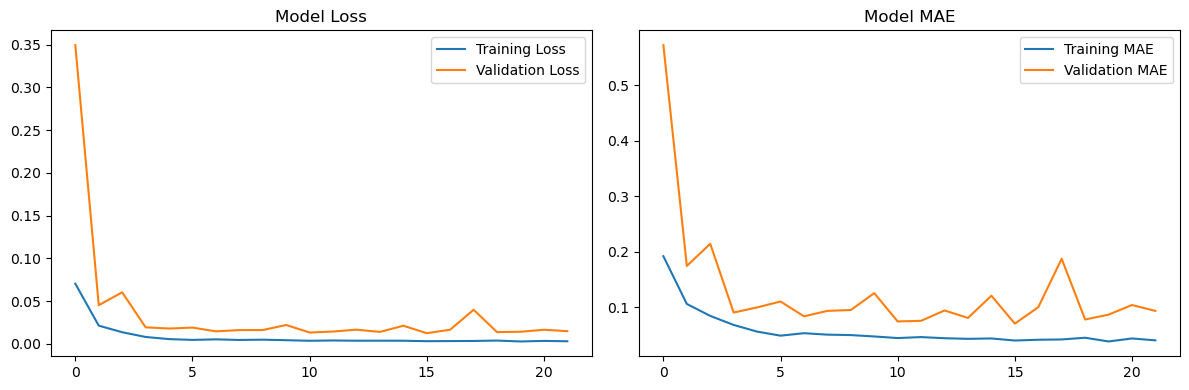


Model Eval. Metrics: rmse: 0.020, mae: 0.012, r2: 0.947




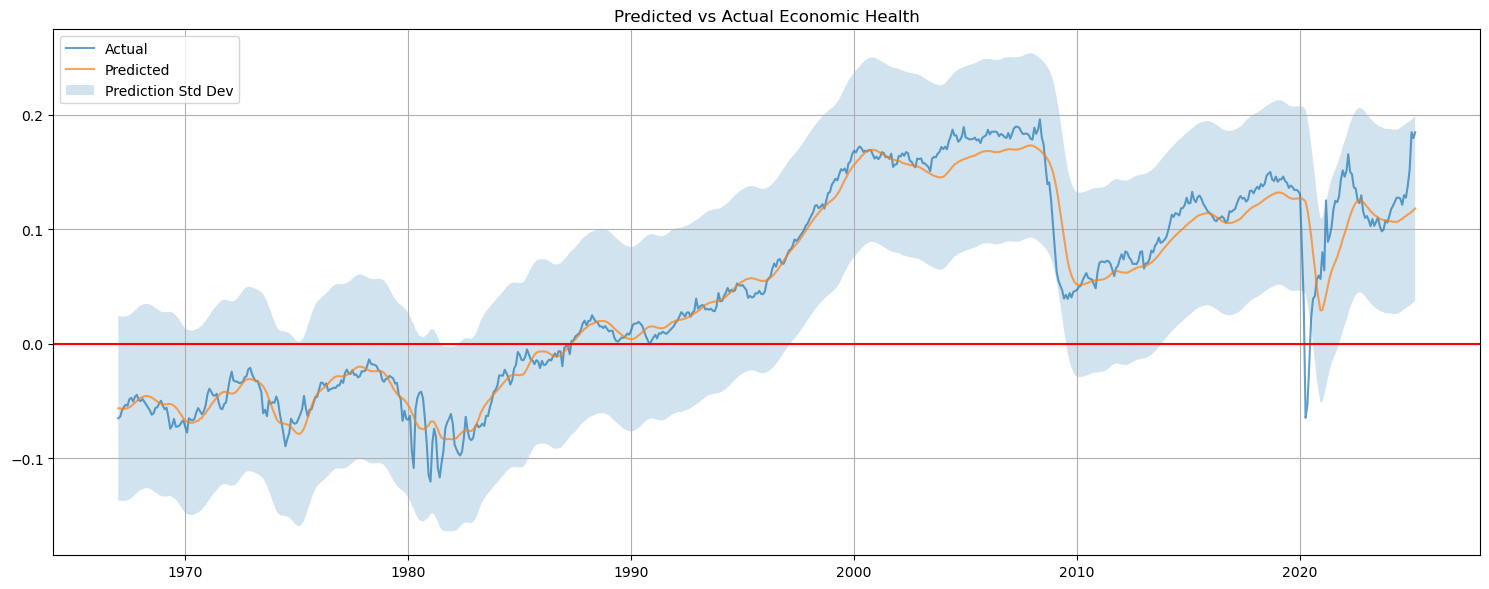

In [122]:
# Economic health prediction class.
class EconomicHealthPredictor:
    def __init__(self, lookback=12):
        """
        Initialize predictor with specified lookback period.
        Args:
            lookback: Number of previous time steps to consider for prediction (default: 12).
        """
        self.lookback = lookback
        self.scaler_X = MinMaxScaler()    # Scaler for input features.
        self.scaler_y = MinMaxScaler()    # Scaler for target variable.
        self.model = None                 # NN model placeholder. The NN not yet created.

    def create_composite_health_score(self, data):
        """
        Creates a composite index of economic health with updated indicators.
        
        Positive indicators (Sum = 1): 
        - GDP (core economic growth indicator)
        - INDPRO (industrial production)
        - SP500 (market stability)
        - PAYEMS (employment)
        - GDP_PCA (population welfare)
        - PASAVERT (population savings)
        - TAX (tax revenues)
        - INTEREST (interest payments on government loans)
        - T10YFF (yield curve slope)

        Negative indicators (Sum = -1):
        - DEBT (total public debt)
        - CPI (inflation)
        - UNEMPLOYMENT (unemployment)
        - FEDFUNDS (cost of borrowing)
        - DEBT_PER_GDP (debt burden)
        - TB (trade deficit)
        - ASTDSL (total indebtedness)
        - FGEXPND (government spending)
        """
        weights = {
        # Positive indicators (total sum = 1).
            'gdp': 0.15,          # A key indicator of economic growth.
            'indpro': 0.15,       # Production capacity.
            'sp500': 0.1,         # Market confidence.
            'payems': 0.1,        # Employment.
            'gdp_pca': 0.15,      # Standard of living.
            'pasavert': 0.1,      # Household financial stability.
            'tax': 0.1,           # Tax revenues.
            'interest': 0.1,      # Interest payments.
            't10yff': 0.05,       # Yield curve slope.
    
        # Negative indicators (total sum = -1).
            'debt': -0.25,        # A major problem for the economy.
            'cpi': -0.15,         # Inflation.
            'unrate': -0.1,       # Social indicator.
            'fedfunds': -0.1,     # Impact on the cost of loans.
            'debt_per_gdp': -0.1, # Long-term financial stability.
            'tb': -0.1,           # Trade balance.
            'astdsl': -0.1,       # Energy dependence.
            'fgexpnd': -0.1       # Government spending.
       }
        # Normalize input data using MinMaxScaler.
        normalized_data = self.scaler_X.fit_transform(data)
        df_normalized = pd.DataFrame(normalized_data, columns=data.columns)

        # Calculate weighted sum of indicators.
        health_score = sum(
            df_normalized[col] * weight for col, weight in weights.items() if col in df_normalized.columns
        )
        return health_score

    def prepare_sequences(self, X, y):
        """
        Create sequences of lookback periods for time series prediction.
        Args:
            X: Input features array.
            y: Target values array.
        
        Returns:
            Tuple of (X sequences, y sequences) for model training.
        """
        X_seq, y_seq = [], []
        for i in range(len(X) - self.lookback):
            X_seq.append(X[i:(i + self.lookback)])
            y_seq.append(y[i + self.lookback])
        return np.array(X_seq), np.array(y_seq)

    def build_model(self, input_shape):
        """
        Creates a model.
        """
        # Hybrid CNN-LSTM architecture for time series prediction.
        model = Sequential([
            Conv1D(128, kernel_size=5, activation='relu', input_shape=input_shape),
            MaxPooling1D(pool_size=2),
            LSTM(256, return_sequences=True),
            Dropout(0.3),
            LSTM(128, return_sequences=False),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return model

    def fit(self, X, epochs=22, validation_split=0.2, verbose=0):
        """
        Train the model on input data.
        Args:
            X: Input features DataFrame.
            epochs: Number of training epochs.
            validation_split: Fraction of data to use for validation.
            verbose: Verbosity level of training output.
        Returns:
            Training history.
        """
        # Calculate health score and scale data.
        y = self.create_composite_health_score(X)
        X_scaled = self.scaler_X.fit_transform(X)
        y_scaled = self.scaler_y.fit_transform(y.values.reshape(-1, 1))

        # Prepare sequences for time series prediction.
        X_seq, y_seq = self.prepare_sequences(X_scaled, y_scaled)
        self.model = self.build_model((self.lookback, X.shape[1]))

        # Add early stopping to prevent overfitting.
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = self.model.fit(
            X_seq, y_seq,
            epochs=epochs,
            validation_split=validation_split,
            callbacks=[early_stopping],
            verbose=verbose
        )
        return history

    def predict(self, X):
        """
        Make predictions on new data.
        Args:
            X: Input features DataFrame.
            
        Returns:
            Array of predicted values in original scale.
        """
        X_scaled = self.scaler_X.transform(X)
        X_seq, _ = self.prepare_sequences(X_scaled, np.zeros(len(X_scaled)))
        predictions = self.model.predict(X_seq, verbose=0)
        return self.scaler_y.inverse_transform(predictions)

# Main analysis function.
def run_analysis(data):
    print("Training the model...")
    predictor = EconomicHealthPredictor(lookback=12)
    history = predictor.fit(data, epochs=22, validation_split=0.2, verbose=0)

    # Add back the training history plot.
    plot_training_history(history)

    # Making predictions.
    predictions = predictor.predict(data)
    health_score = predictor.create_composite_health_score(data)

    # Add model evaluation.
    metrics = model_evaluation(health_score[12:], predictions)
    
    # Print metrics.
    print("\nModel Eval. Metrics:", end=' ')
    print(", ".join(f"{metric}: {value:.3f}" for metric, value in metrics.items()))
    print("\n")
    
    # Visualization of predictions.
    plot_predictions(health_score[12:], predictions, data.index[12:])

    return predictor, history, predictions, health_score, metrics

# Performing the analysis.
if __name__ == "__main__":
    # If we are loading data from a file.
    # data = pd.read_csv("data/data.csv", index_col=0, parse_dates=True)
    predictor = run_analysis(data)

**Model Loss**
**Loss** is a measure of how well or poorly a model performs during training. It is a numerical value that shows the difference between the model's predictions and the true values.
The Loss function depends on the type of task:
- For **regression**, **Mean Squared Error (MSE)** or **Mean Absolute Error (MAE)** is often used.
- For **classification**, **Cross-Entropy Loss** is often used.
The plot of **Loss** usually shows the value of the loss versus the epochs.
- **The goal is for the loss to decrease with each epoch**, which means the model is learning and getting better.
If the loss:
    - Decreases smoothly: the model is training well.
    - Stops decreasing or starts increasing: there may be **overfitting** (the model is adapting too much to the training data).
    - Does not decrease at all: the model may not learn (it is possible that the learning rate is too small or the architecture is not suitable).

**Model MAE (Mean Absolute Error)**
**Mean Absolute Error (MAE)** is a metric that measures the average absolute difference between the predicted values ​​and the true values.
- The formula for MAE is: $$ MAE = \frac{1}{n} \sum_{i=1}^n |y_i - \hat{y}_i| $$
where: $ y_i \text{ are the true values, } \hat{y}_i \text{ are the predicted values} $, **n** is the number of examples.
Like Loss, MAE is also plotted against epochs.
- **The goal is for MAE to decrease over time**, indicating that the model is making more accurate predictions.
- MAE is easier to interpret than Loss because it is in the same units as the input data (for example, if you are predicting temperature in degrees, MAE will also be in degrees).

Are we done with this? Probably not. In the late 1970s, the US economy and the purchasing power of the dollar were in their heyday. And inflation over the decades does not stop working, which significantly distorts the picture. That is, if at the beginning we have apples, at the end of the period we have pears. How do we compare which is bigger, apples or pears?<br>
**<a style="color:purple;">For an objective analysis, we need to exclude inflation</a>** from the general picture. How? By multiplying the features that are measured in dollars by some factor that takes into account inflation.

#### 3.2 **Second simulation**:

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/CUUR0000SA0R)** we download information for the period of our study: **<a style="color:purple;">Purchasing Power of the Consumer Dollar in U.S. City Average (CUUR0000SA0R)</a>**. [20] Units: **Index**, Frequency: Monthly.

In [55]:
deflator = pd.read_csv('data/CUUR0000SA0R.csv') # Loading data.
deflator.columns = ["date", "deflator"]
deflator['deflator'] = deflator['deflator'] / 100 # Convert the percentage index to a number.
deflator['date'] = pd.to_datetime(deflator['date'])
deflator.set_index('date', inplace=True)
deflator.tail()

,deflator
date,
2024-11-01,0.317
2024-12-01,0.317
2025-01-01,0.315
2025-02-01,0.313
2025-03-01,0.313


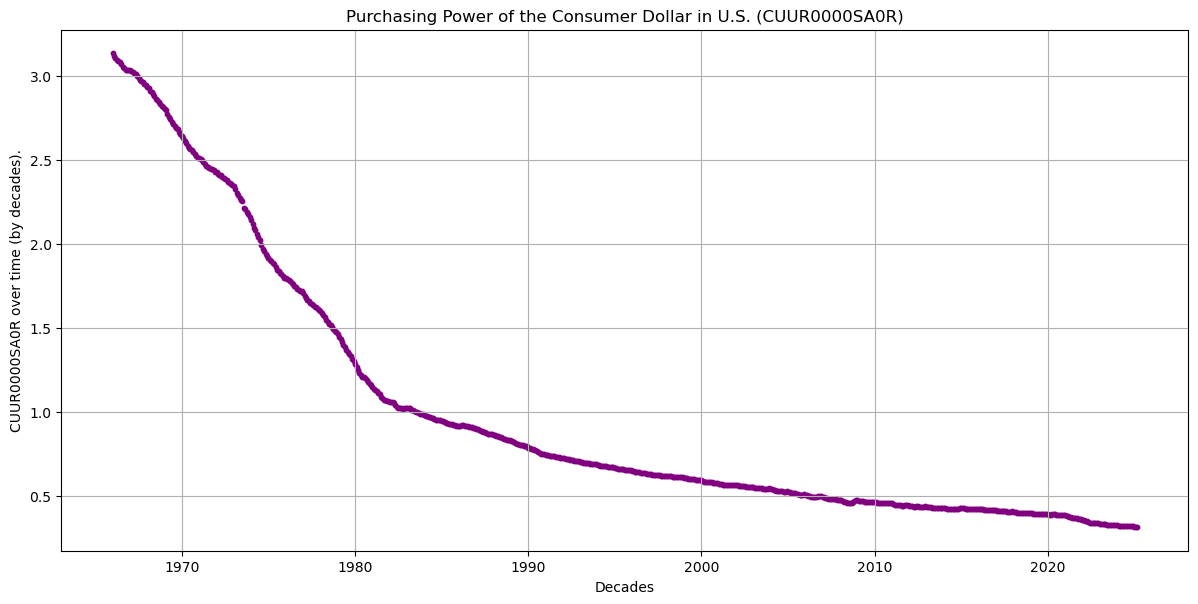

In [56]:
# Create the chart.
plt.figure(figsize=(12, 6))
plt.xlabel('Decades')
plt.grid(True)
plt.tight_layout()
plt.scatter(deflator.index, deflator['deflator'], s=10, color='purple') # s = the point size
# Readability settings.
plt.ylabel('CUUR0000SA0R over time (by decades).')
plt.title('Purchasing Power of the Consumer Dollar in U.S. (CUUR0000SA0R)')
plt.show()

In [57]:
# Create a copy of the original DataFrame.
adjusted_data = data.copy()

# List of dollar columns to be adjusted.
usd_columns = ['gdp', 'debt', 'gdp_pca', 'tb', 'astdsl', 'interest', 'tax', 'fgexpnd']

# Multiply the values ​​in the columns by the deflator.
for col in usd_columns:
    adjusted_data[col] = data[col] * deflator['deflator']

Once inflation is eliminated, another problem will arise. The economy will not go from boom to boom, from bright to even brighter future. And it will be almost impossible for the model to pass metrics with over 90% accuracy. It's tried and tested. More information describing anomalies in the economy could be added to help model efficiency. Two more features were chosen: recessions and the COVID-19 period. But this did not produce good results either.<br>
The problem was solved with **cross-validation** and adjustments to the model's hyperparameters. In addition, **months were removed** from the **COVID-19 period in such a way as not to interfere with the trend** in price movements. And why were they removed at all? Because of their **anti-market value**. At that time, businesses were being forced to close and "helicopter money" was being given out.

In [59]:
# Define a start and end date.
start_date = pd.Timestamp('2020-01-01')
end_date = pd.Timestamp('2021-11-01')

# List of all columns.
columns = ['gdp', 'cpi', 'indpro', 'sp500', 'payems', 'unrate', 'fedfunds', 
           'debt', 'pasavert', 'gdp_pca', 'debt_per_gdp', 'tb', 'astdsl', 
           'interest', 'tax', 'fgexpnd', 't10yff']

# Period selection mask.
period_mask = (adjusted_data.index >= start_date) & (adjusted_data.index <= end_date)

# Creating a dataframe with the correct columns and data types.
data_dict = {col: pd.Series(dtype='float64') for col in columns}
interpolation_df = pd.DataFrame(data_dict, index=[start_date, end_date])

# Copy the values ​​for the start and end date.
for col in columns:
    interpolation_df.loc[start_date, col] = float(adjusted_data.loc[start_date, col])
    interpolation_df.loc[end_date, col] = float(adjusted_data.loc[end_date, col])

# Add the intermediate dates and perform interpolation.
interpolation_df = interpolation_df.reindex(adjusted_data.loc[period_mask].index)
interpolation_df = interpolation_df.interpolate(method='linear')

# Updating the original dataframe.
adjusted_data.loc[period_mask, columns] = interpolation_df[columns]

adjusted_data.to_csv(r'data/adjusted_data.csv') # We save the dataframe to a file.
adjusted_data # View the corrected DataFrame.

,gdp,cpi,indpro,sp500,payems,unrate,fedfunds,debt,pasavert,gdp_pca,debt_per_gdp,tb,astdsl,interest,tax,fgexpnd,t10yff
date,,,,,,,,,,,,,,,,,
1966-01-01,2.495422e+12,31.880,33.1709,92.88,62529.0,0.040,0.0442,1.006653e+12,0.112,75803.392000,0.403400,-1.097600e+07,1.470674e+12,6.096384e+10,3.094981e+11,4.266716e+11,0.288095
1966-02-01,2.490709e+12,32.080,33.3859,91.22,62796.0,0.038,0.0460,9.957801e+11,0.110,75388.043333,0.399798,-1.122480e+07,1.465383e+12,6.120426e+10,3.121700e+11,4.308109e+11,0.242632
1966-03-01,2.490697e+12,32.180,33.8429,89.23,63192.0,0.038,0.0466,9.868725e+11,0.107,75117.574667,0.396223,-1.149220e+07,1.462881e+12,6.155678e+10,3.153998e+11,4.357159e+11,0.229565
1966-04-01,2.491416e+12,32.280,33.8967,91.06,63437.0,0.038,0.0467,9.783202e+11,0.103,74871.145000,0.392676,-1.176100e+07,1.460828e+12,6.192476e+10,3.186983e+11,4.407125e+11,0.111500
1966-05-01,2.504108e+12,32.350,34.2192,86.13,63712.0,0.039,0.0490,9.862882e+11,0.112,74932.558667,0.393868,-1.205880e+07,1.467303e+12,6.235946e+10,3.197540e+11,4.449872e+11,-0.057143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-01,9.449175e+12,316.449,101.9503,6032.38,158619.0,0.042,0.0464,1.148084e+13,0.039,21861.376667,1.215010,-2.528138e+10,1.969142e+13,3.553696e+11,1.015516e+12,2.260008e+12,-0.290000
2024-12-01,9.475884e+12,317.603,103.0723,5881.63,158942.0,0.041,0.0448,1.148039e+13,0.035,21847.851333,1.211538,-3.073252e+10,1.977650e+13,3.543031e+11,1.023070e+12,2.266193e+12,-0.093333
2025-01-01,9.442641e+12,319.086,103.2131,6040.53,159053.0,0.040,0.0433,1.140751e+13,0.041,21696.570000,1.208084,-4.103600e+10,1.973627e+13,3.510080e+11,1.024122e+12,2.258041e+12,0.299048


Training the model...
Performing cross-validation...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
Cross-Validation Metrics: rmse: 0.063, mae: 0.048, r2: 0.938


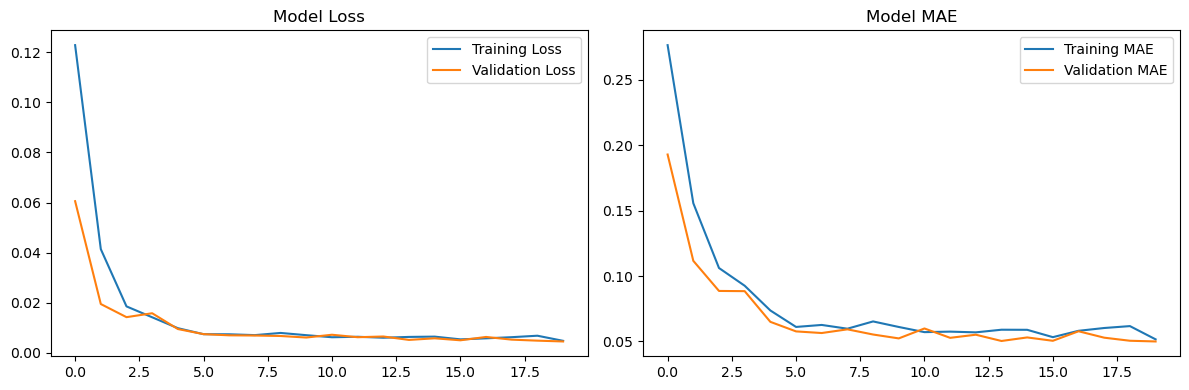


Model Eval. Metrics: rmse: 0.016, mae: 0.012, r2: 0.942




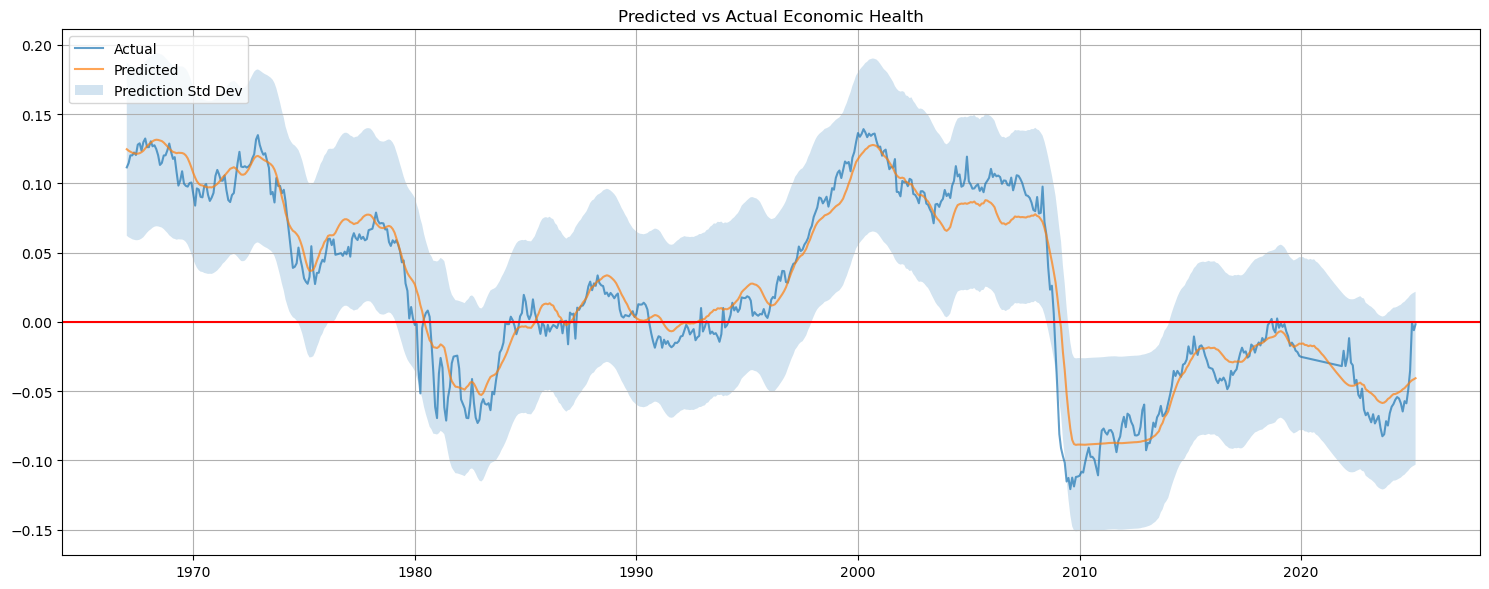

In [130]:
class EconomicHealthPredictor:
    def __init__(self, lookback=12):
        """
        Initialize the Economic Health Predictor.
        Args:
            lookback: Number of time steps to look back for predictions (default: 12 months).
        """
        self.lookback = lookback
        self.scaler_X = MinMaxScaler()    # Feature scaler.
        self.scaler_y = MinMaxScaler()    # Target variable scaler.
        self.model = None                 # Neural network model placeholder.

    @tf.function
    def _create_predict_function(self, inputs):
        return self.model(inputs, training=False)

    def create_composite_health_score(self, adjusted_data):
        """
        Calculate composite economic health score from multiple indicators.
        """
        weights = {
        # Positive indicators (total sum = 1).
            'gdp': 0.15,
            'indpro': 0.15,
            'sp500': 0.1,
            'payems': 0.1,
            'gdp_pca': 0.15,
            'pasavert': 0.1,
            'tax': 0.1,
            'interest': 0.1,
            't10yff': 0.05,
    
        # Negative indicators (total sum = -1).
            'debt': -0.25,
            'cpi': -0.15,
            'unrate': -0.1,
            'fedfunds': -0.1,
            'debt_per_gdp': -0.1,
            'tb': -0.1,
            'astdsl': -0.1,
            'fgexpnd': -0.1
       }
        # Scale the input data and calculate weighted health score.
        normalized_data = self.scaler_X.fit_transform(adjusted_data)
        df_normalized = pd.DataFrame(normalized_data, columns=adjusted_data.columns)
        health_score = sum(df_normalized[col] * weight for col, weight in weights.items() if col in df_normalized.columns)
        return health_score

    def prepare_sequences(self, X, y):
        """
        Prepare time series sequences for model training.
        Args:
            X: Input features array.
            y: Target values array.
        """
        X_seq, y_seq = [], []
        for i in range(len(X) - self.lookback):
            X_seq.append(X[i:(i + self.lookback)])
            y_seq.append(y[i + self.lookback])
        return np.array(X_seq), np.array(y_seq)

    def build_model(self, input_shape):
        """
        Creates a model.
        """
        # Deep CNN-LSTM hybrid architecture.
        model = Sequential([
            Conv1D(128, kernel_size=5, activation='relu', input_shape=input_shape),
            MaxPooling1D(pool_size=2),
            LSTM(512, return_sequences=True),
            Dropout(0.4),
            LSTM(256, return_sequences=True),
            Dropout(0.3),
            LSTM(128, return_sequences=False),
            Dropout(0.2),
            Dense(64, activation='relu'),
            Dense(1)
        ])
        # Configure optimizer with custom learning rate.
        optimizer = Adam(learning_rate=1e-3)
        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        return model

    def fit(self, adjusted_data, epochs=20, validation_split=0.2, verbose=0):
        """
        Train the model on the provided data.
        Args:
            adjusted_data: Input features DataFrame.
            epochs: Number of training epochs.
            validation_split: Fraction of data for validation.
            verbose: Training output verbosity level.
        """
        # Prepare data for training.
        y = self.create_composite_health_score(adjusted_data)
        X_scaled = self.scaler_X.fit_transform(adjusted_data)
        y_scaled = self.scaler_y.fit_transform(y.values.reshape(-1, 1))
        X_seq, y_seq = self.prepare_sequences(X_scaled, y_scaled)
        
        # Initialize model and training settings.
        self.model = self.build_model((self.lookback, adjusted_data.shape[1]))
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = self.model.fit(
            X_seq, y_seq,
            epochs=epochs,
            validation_split=validation_split,
            callbacks=[early_stopping],
            verbose=verbose,
            batch_size=32
        )
        return history

    def cross_validate(self, adjusted_data, epochs=20, k=5):
        """
        Perform k-fold cross-validation.
        Args:
            adjusted_data: Input features DataFrame.
            epochs: Number of training epochs per fold.
            k: Number of folds for cross-validation.
        Returns:
            Average metrics across folds and training history.
        """
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        metrics_list = []

        # Prepare data for cross-validation.
        y = self.create_composite_health_score(adjusted_data)
        X_scaled = self.scaler_X.fit_transform(adjusted_data)
        y_scaled = self.scaler_y.fit_transform(y.values.reshape(-1, 1))
        X_seq, y_seq = self.prepare_sequences(X_scaled, y_scaled)

        # Perform k-fold cross-validation.
        for train_index, test_index in kf.split(X_seq):
            X_train, X_test = X_seq[train_index], X_seq[test_index]
            y_train, y_test = y_seq[train_index], y_seq[test_index]

            self.model = self.build_model((self.lookback, adjusted_data.shape[1]))
            history = self.model.fit(X_train, y_train, epochs=epochs, verbose=0, batch_size=32, validation_data=(X_test, y_test))

            preds = self.model.predict(X_test)
            metrics = model_evaluation(y_test, preds)
            metrics_list.append(metrics)

        # Calculate average metrics across folds.
        avg_metrics = {key: np.mean([m[key] for m in metrics_list]) for key in metrics_list[0]}
        return avg_metrics, history

    def predict(self, adjusted_data):
        """
        Make predictions on new data.
        Args:
            adjusted_data: Input features DataFrame.
        Returns:
            Array of predicted values in original scale.
        """
        X_scaled = self.scaler_X.transform(adjusted_data)
        X_seq, _ = self.prepare_sequences(X_scaled, np.zeros(len(X_scaled)))
        predictions = self._create_predict_function(X_seq)
        return self.scaler_y.inverse_transform(predictions)

# Main analysis function.
def run_analysis(adjusted_data):
    print("Training the model...")
    predictor = EconomicHealthPredictor(lookback=12)
    history = predictor.fit(adjusted_data, epochs=20, validation_split=0.2, verbose=0)

    # Cross-validation.
    print("Performing cross-validation...")
    cv_metrics, cv_history = predictor.cross_validate(adjusted_data, epochs=20, k=5)
    print("Cross-Validation Metrics: " + ", ".join(f"{metric}: {value:.3f}" for metric, value in cv_metrics.items()))

    # Plot training history after cross-validation.
    plot_training_history(cv_history)

    # Making predictions.
    predictions = predictor.predict(adjusted_data)
    health_score = predictor.create_composite_health_score(adjusted_data)
    
    # Add model evaluation.
    metrics = model_evaluation(health_score[12:], predictions)
    
    # Print metrics.
    print("\nModel Eval. Metrics:", end=' ')
    print(", ".join(f"{metric}: {value:.3f}" for metric, value in metrics.items()))
    print("\n")

    # Visualization of predictions.
    plot_predictions(health_score[12:], predictions, adjusted_data.index[12:])
    return predictor, history, predictions, health_score, metrics

# Performing the analysis.
if __name__ == "__main__":
    # Loading the data.
    adjusted_data = pd.read_csv("data/adjusted_data.csv", index_col=0, parse_dates=True)
    # Training and analysis.
    predictor, history, predictions, health_score, metrics = run_analysis(adjusted_data)

BINGO! Those who know the phases of development of the US economy **can now clearly determine the periods of rise, fall and stagnation! <a style="color:purple;">And they coincide with what historical truth says</a>**.<br>
Let's try to predict what will happen in the next 9 months. Why 9? Because the data collection is delayed by 3 months. That is, we have 6 months of current forecast left.

In [62]:
def predict_next_months(predictor, adjusted_data, months=9):
    """
    Predict the next 'months' months using the trained predictor model.
    """
    # Extract the latest data for prediction.
    last_data = adjusted_data.iloc[-predictor.lookback:].values
    last_data_scaled = predictor.scaler_X.transform(last_data)
    predictions = []

    for _ in range(months):
        # Prepare the sequence.
        last_seq = last_data_scaled[-predictor.lookback:].reshape(1, predictor.lookback, -1)
        
        # Predict the next month.
        next_prediction_scaled = predictor.model.predict(last_seq, verbose=0)[0]
        next_prediction = predictor.scaler_y.inverse_transform(next_prediction_scaled.reshape(-1, 1))[0, 0]
        predictions.append(next_prediction)
        
        # Update the sequence with the predicted value.
        next_data_scaled = np.append(last_data_scaled[-1, 1:], next_prediction_scaled).reshape(1, -1)
        last_data_scaled = np.vstack((last_data_scaled, next_data_scaled))

    return predictions

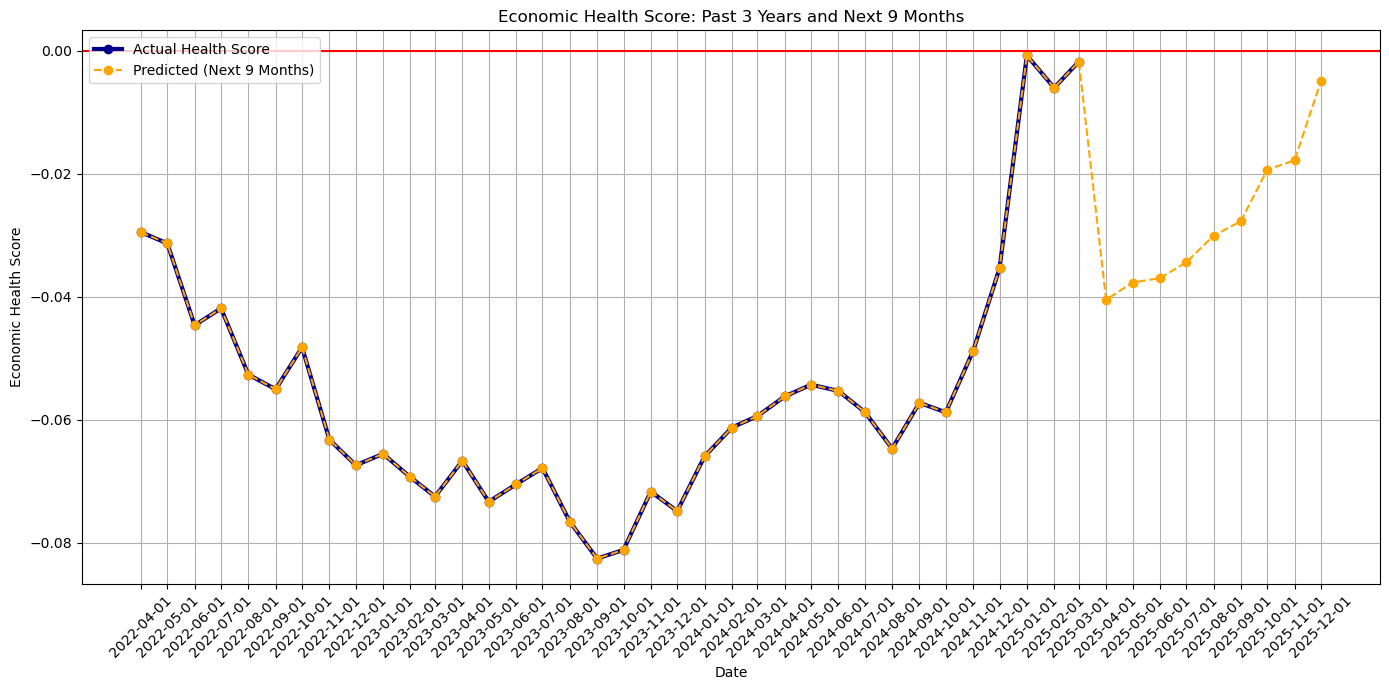

In [136]:
# Forecast for next 9 months.
next_9_months_predictions = predict_next_months(predictor, adjusted_data, months=9)
# Create future dates (without gap between August and September).
future_dates = pd.date_range(start=adjusted_data.index[-1] + pd.offsets.MonthBegin(1), periods=9, freq='MS')
# Historical data (without last month to avoid gap).
historical_dates = adjusted_data.index[-36:]

# Forecast data should start from the next month after the last historical month.
all_dates = historical_dates.append(future_dates)
# Combining historical values with forecasted ones.
extended_health_score = np.concatenate((health_score.values[-36:], next_9_months_predictions))

# Display the plot.
plt.figure(figsize=(14, 7))
# Historical data with darker blue color and thicker line.
plt.plot(
    historical_dates, 
    health_score[-36:], 
    label="Actual Health Score", 
    color="darkblue",  # Darker blue color.
    linestyle="-", 
    marker="o", 
    linewidth=3  # Increased line thickness.
)
# Forecasted data.
plt.plot(
    all_dates,  # Combine historical and forecast dates.
    extended_health_score,  # Combine historical and forecast values.
    label="Predicted (Next 9 Months)", 
    color="orange", 
    linestyle="--", 
    marker="o"
)
# Add zero line for better visualization.
plt.axhline(y=0, color='r', linestyle='-')
# Title and legend.
plt.title("Economic Health Score: Past 3 Years and Next 9 Months")
plt.xlabel("Date")
plt.ylabel("Economic Health Score")
plt.legend(loc='upper left')
# Change frequency of monthly labels on X axis.
plt.xticks(all_dates, rotation=45)
# Add grid for better visualization.
plt.grid(True)
# Improve visualization.
plt.tight_layout()
plt.show()

What can we read from the graph? The US economy will fluctuate around our virtual zero in the near future. Which means that it is not threatened by anything unusual.<br>
What's the last question we can ask ourselves? So far in this 3-part study, we've seen that the **economy is in good shape because of constant infusions of money from loans**. How long can this all continue? **How long** can the effect of "helicopter money" ([US Debt Clock](https://usdebtclock.org/)) last? According to economists dealing with the subject, **until the debts reach 200% of the Gross Domestic Product** (GDP). In a bad geopolitical situation up to 175%. [21] Of course, the geopolitical situation is very bad now, so we **are stopping at a value of 175%**.

### 4. **Debt forecasting**

#### 4.1 Using Deep Learning model.

**Input**: GDP, W006RC1Q027SBEA, FEDFUNDS, CPIAUCSL, GFDEBTN, BOPGSTB, FGEXPND<br>
**Target**: Total Public Debt as Percent of Gross Domestic Product (GFDEGDQ188S)<br>
**Model**: The first one that was described. But only the features that are directly related to the Debt/GDP ratio were taken!<br>
**Objective**: To predict the future Debt/GDP ratio for 36 months ahead.

Positive:<br>
 + GDP (core economic growth indicator)<br>
 + W006RC1Q027SBEA (tax revenues)<br>

Negative:<br>
 - GFDEBTN (total public debt)<br>
 - CPIAUCSL (inflation)<br>
 - FEDFUNDS (cost of borrowing)<br>
 - BOPGSTB (trade deficit)<br>
 - FGEXPND (government spending)<br>

Running K-fold Cross-Validation...

Average Cross-Validation Metrics:
rmse: 0.026
mae: 0.018
r2: 0.992


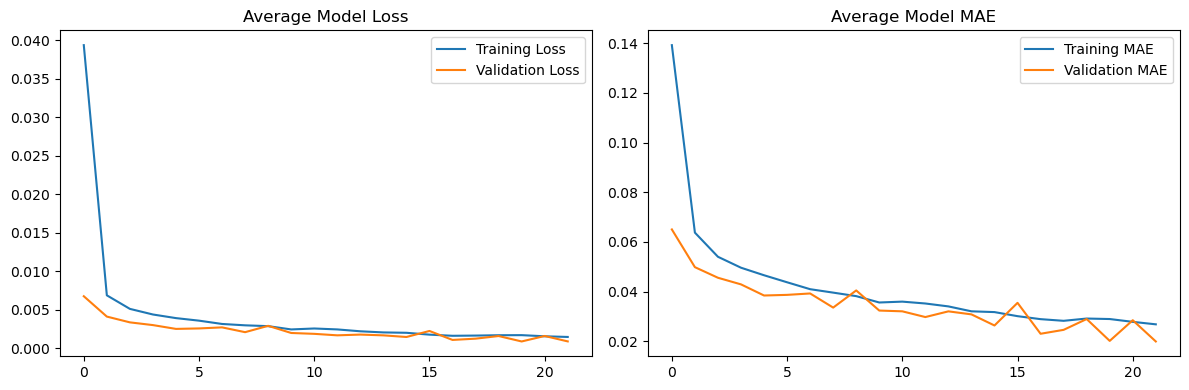

In [140]:
# Function to visualize model predictions against actual values.
def plot_predictions(true_values, predictions, dates):
    """
    Create a comparison plot of predicted vs actual values.
    Args:
        true_values: Array of actual values.
        predictions: Array of model predictions.
        dates: Array of corresponding dates for x-axis.
    """
    plt.figure(figsize=(15, 6))
    plt.plot(dates, true_values, label='Actual', alpha=0.7)
    plt.plot(dates, predictions, label='Predicted', alpha=0.7)
    plt.title('Predicted vs Actual Debt-to-GDP Ratio')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# Economic health prediction class.
class EconomicHealthPredictor:
    def __init__(self, lookback=12):
        """
        Initialize predictor with specified lookback period.
        Args:
            lookback: Number of previous time steps to consider for prediction (default: 12).
        """
        self.lookback = lookback
        self.scaler_X = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        self.model = None

    def prepare_sequences(self, X, y):
        """
        Create sequences of lookback periods for time series prediction.
        Args:
            X: Input features array.
            y: Target values array.
        Returns:
            Tuple of (X sequences, y sequences) for model training.
        """
        X_seq, y_seq = [], []
        for i in range(len(X) - self.lookback):
            X_seq.append(X[i:(i + self.lookback)])
            y_seq.append(y[i + self.lookback])
        return np.array(X_seq), np.array(y_seq)

    def build_model(self, input_shape):
        """
        Creates a model.
        """
        model = Sequential([
            Conv1D(128, kernel_size=5, activation='relu', input_shape=input_shape),
            MaxPooling1D(pool_size=2),
            LSTM(256, return_sequences=True),
            Dropout(0.3),
            LSTM(128, return_sequences=False),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return model

    def fit(self, data, target_column, epochs=22, validation_split=0.2, verbose=0):
        """
        Train the model on input data.
        Args:
            data: Input DataFrame with features and target.
            target_column: Name of the target column.
            epochs: Number of training epochs.
            validation_split: Fraction of data to use for validation.
            verbose: Verbosity level of training output.
        Returns:
            Training history.
        """
        # Select specified features and target.
        features = ['gdp', 'tax', 'fedfunds', 'cpi', 'debt', 'tb', 'fgexpnd']
        X = data[features]
        y = data[target_column]

        # Scale data.
        X_scaled = self.scaler_X.fit_transform(X)
        y_scaled = self.scaler_y.fit_transform(y.values.reshape(-1, 1))

        # Prepare sequences for time series prediction.
        X_seq, y_seq = self.prepare_sequences(X_scaled, y_scaled)
        self.model = self.build_model((self.lookback, X.shape[1]))

        # Early stopping to prevent overfitting.
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = self.model.fit(
            X_seq, y_seq,
            epochs=epochs,
            validation_split=validation_split,
            callbacks=[early_stopping],
            verbose=verbose
        )
        return history

    def predict(self, data):
        """
        Make predictions on new data.
        Args:
            data: Input DataFrame with features.
        Returns:
            Array of predicted values in original scale.
        """
        features = ['gdp', 'tax', 'fedfunds', 'cpi', 'debt', 'tb', 'fgexpnd']
        X = data[features]
        X_scaled = self.scaler_X.transform(X)
        X_seq, _ = self.prepare_sequences(X_scaled, np.zeros(len(X_scaled)))
        predictions = self.model.predict(X_seq, verbose=0)
        return self.scaler_y.inverse_transform(predictions)

# Main analysis function.
def run_analysis(data):
    print("Running K-fold Cross-Validation...")
    target = 'debt_per_gdp'
    predictor = EconomicHealthPredictor(lookback=12)

    features = ['gdp', 'tax', 'fedfunds', 'cpi', 'debt', 'tb', 'fgexpnd']
    X = data[features]
    y = data[target]

    # Scale data.
    X_scaled = predictor.scaler_X.fit_transform(X)
    y_scaled = predictor.scaler_y.fit_transform(y.values.reshape(-1, 1))

    # Prepare sequences.
    X_seq, y_seq = predictor.prepare_sequences(X_scaled, y_scaled)

    # K-fold cross-validation.
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_metrics = []
    histories = []

    for fold, (train_index, val_index) in enumerate(kf.split(X_seq), start=1):
        X_train, X_val = X_seq[train_index], X_seq[val_index]
        y_train, y_val = y_seq[train_index], y_seq[val_index]

        predictor.model = predictor.build_model((predictor.lookback, X.shape[1]))

        history = predictor.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=22,
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
            verbose=0
        )

        # Store training history for later visualization.
        histories.append(history)

        # Evaluate on validation set.
        val_predictions = predictor.model.predict(X_val, verbose=0)
        metrics = model_evaluation(predictor.scaler_y.inverse_transform(y_val),
                                   predictor.scaler_y.inverse_transform(val_predictions))
        fold_metrics.append(metrics)

    # Average metrics over folds.
    avg_metrics = {
        metric: np.mean([fold[metric] for fold in fold_metrics]) for metric in fold_metrics[0]
    }

    print("\nAverage Cross-Validation Metrics:")
    for metric, value in avg_metrics.items():
        print(f"{metric}: {value:.3f}")

    # Plot average training history.
    avg_history = {
        'loss': np.mean([h.history['loss'] for h in histories], axis=0),
        'val_loss': np.mean([h.history['val_loss'] for h in histories], axis=0),
        'mae': np.mean([h.history['mae'] for h in histories], axis=0),
        'val_mae': np.mean([h.history['val_mae'] for h in histories], axis=0)
    }
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(avg_history['loss'], label='Training Loss')
    plt.plot(avg_history['val_loss'], label='Validation Loss')
    plt.title('Average Model Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(avg_history['mae'], label='Training MAE')
    plt.plot(avg_history['val_mae'], label='Validation MAE')
    plt.title('Average Model MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return predictor, avg_metrics

# Perform the analysis if executed as main script.
if __name__ == "__main__":
    # Example of loading the data.
    # data = pd.read_csv("data.csv", index_col=0, parse_dates=True)
    predictor, avg_metrics = run_analysis(data)

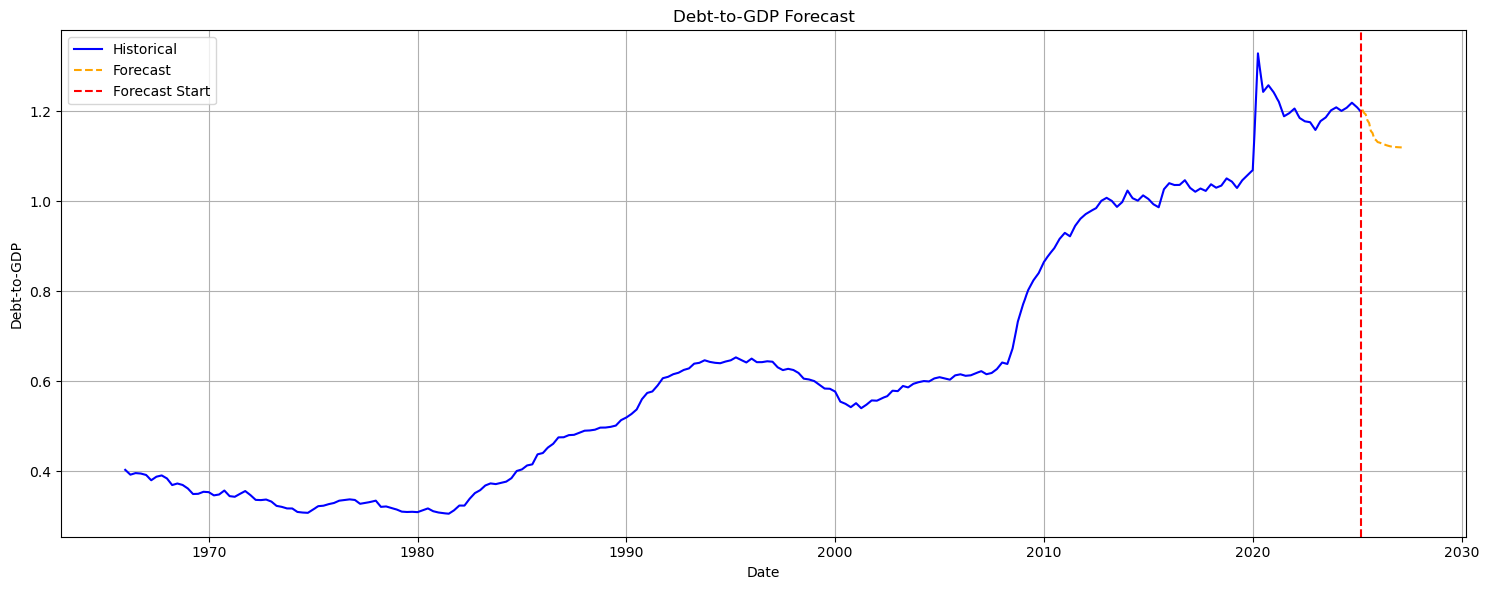

In [67]:
def forecast_future(predictor, data, steps=60):
    """
    Forecast future values for the target variable.
    
    Args:
        predictor: Trained EconomicHealthPredictor object.
        data: DataFrame containing the historical data.
        steps: Number of months to forecast into the future.
    
    Returns:
        DataFrame with historical and forecasted values.
    """
    features = ['gdp', 'tax', 'fedfunds', 'cpi', 'debt', 'tb', 'fgexpnd']
    last_inputs = data[features].iloc[-predictor.lookback:].values
    last_inputs_scaled = predictor.scaler_X.transform(last_inputs)

    future_predictions = []
    for _ in range(steps):
        input_seq = last_inputs_scaled[-predictor.lookback:].reshape(1, predictor.lookback, -1)
        next_pred_scaled = predictor.model.predict(input_seq, verbose=0)[0, 0]
        next_pred = predictor.scaler_y.inverse_transform([[next_pred_scaled]])[0, 0]
        future_predictions.append(next_pred)

        # Update input sequence with the new prediction
        new_input = last_inputs_scaled[-1].copy()
        new_input[-1] = next_pred_scaled  # Update 'debt_per_gdp' equivalent
        last_inputs_scaled = np.vstack([last_inputs_scaled, new_input])

    future_dates = [data.index[-1] + timedelta(days=30 * (i + 1)) for i in range(steps)]
    future_df = pd.DataFrame({'date': future_dates, 'forecast': future_predictions})
    return future_df

# Forecast future values
steps_to_forecast = 24
forecast_df = forecast_future(predictor, data, steps=steps_to_forecast)

# Combine historical and forecasted data
historical_data = data[['debt_per_gdp']].reset_index()
historical_data.columns = ['date', 'actual']
combined_df = pd.concat([
    historical_data,
    forecast_df.rename(columns={'forecast': 'actual'})
])

# Visualize the forecast with a dotted orange line for predictions
plt.figure(figsize=(15, 6))

# Plot historical actual values
plt.plot(historical_data['date'], historical_data['actual'], label='Historical', color='blue')

# Plot forecasted values with dotted orange line
plt.plot(forecast_df['date'], forecast_df['forecast'], linestyle='--', color='orange', label='Forecast')

# Add a vertical line to separate historical and forecast data
plt.axvline(x=pd.Timestamp('2025-03-01'), color='red', linestyle='--', label='Forecast Start')

# Customize the plot
plt.title('Debt-to-GDP Forecast')
plt.xlabel('Date')
plt.ylabel('Debt-to-GDP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 4.2 Using econometrics.

Let's try to make a forecast for the debt of the US economy in a different way. Using the tools of econometrics. **Econometrics** uses **economic** theory, **mathematics**, and **statistical inference** to quantify economic phenomena. The model shown below uses a **vector autoregression (VAR) method** to analyze time series and make forecasts of economic indicators.

Purpose of the model:
 - **To analyze the relationships** between gross domestic product (GDP), debt, and federal tax collected (GDP, debt, and tax).
 - **To forecast their values** ​​for a specified number of months in the future.

How it works:
 - The model takes historical data for the above indicators.
 - Learns how past values ​​are related.
 - Uses these relationships to predict future values.

Output: Forecasts for the values ​​of GDP, debt, and taxes collected.
Forecasts for ratios such as:
 - Debt-to-GDP in percent.
 - Debt-to-Tax in percent.

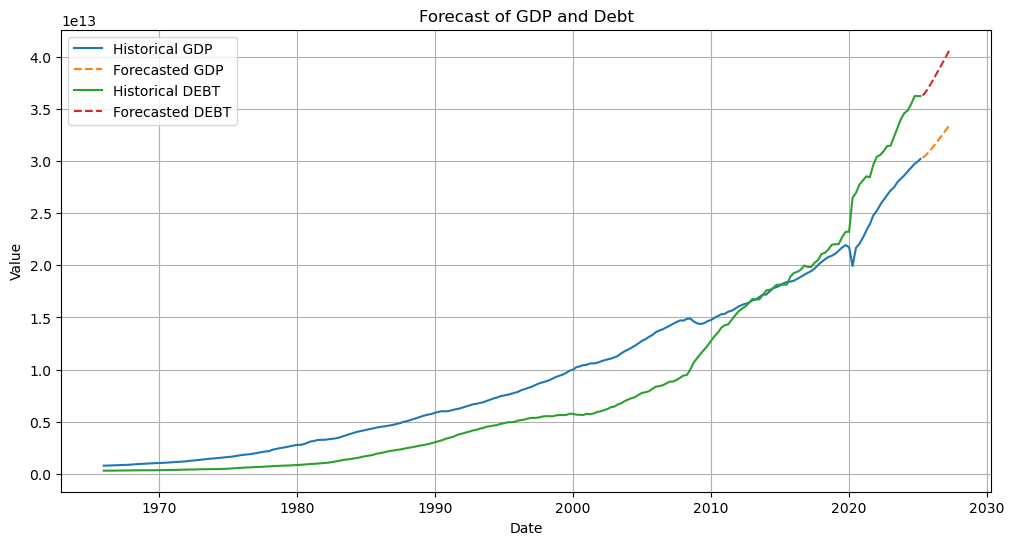

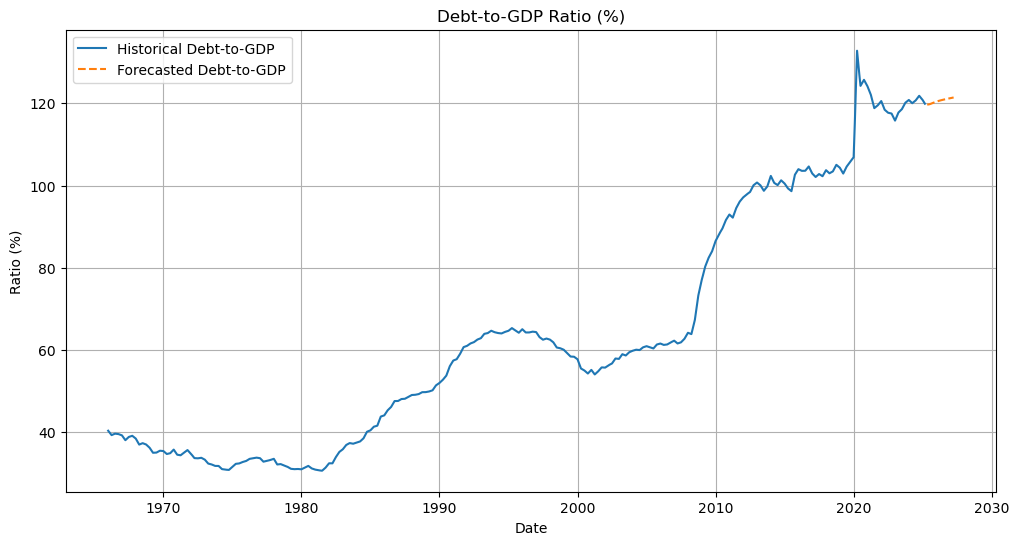

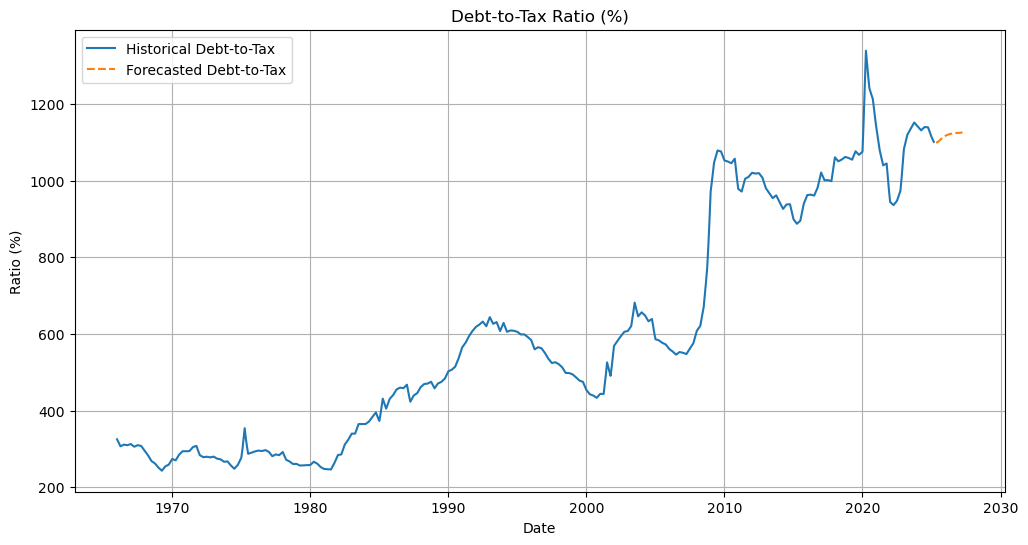


Final forecasted values:
gdp            3.340271e+13
debt           4.056244e+13
debt_to_gdp    1.214346e+02
debt_to_tax    1.125638e+03
Name: 2027-03-31 00:00:00, dtype: float64


In [69]:
class VARModel:
    def __init__(self, lag_order=1):
        self.lag_order = lag_order
        self.model = None

    def fit(self, data):
        # Prepare the data for training.
        self.data = data
        self.model = VAR(self.data)
        self.results = self.model.fit(self.lag_order)
        # print(self.results.summary())

    def forecast(self, steps=24):
        # Generate forecasts for the specified number of steps.
        forecast = self.results.forecast(y=self.data.values[-self.lag_order:], steps=steps)
        forecast_index = pd.date_range(start=self.data.index[-1], periods=steps+1, freq='ME')[1:]
        forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=self.data.columns)

        # Calculate forecasted ratios.
        forecast_df['debt_to_gdp'] = (forecast_df['debt'] / forecast_df['gdp']) * 100
        forecast_df['debt_to_tax'] = (forecast_df['debt'] / forecast_df['tax']) * 100
        return forecast_df

    def plot_forecast(self, forecast_df):
        # Visualize forecasts for GDP and debt.
        plt.figure(figsize=(12, 6))

        for column in ['gdp', 'debt']:
            plt.plot(self.data.index, self.data[column], label=f'Historical {column.upper()}')
            plt.plot(forecast_df.index, forecast_df[column], linestyle='--', label=f'Forecasted {column.upper()}')

        plt.title('Forecast of GDP and Debt')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Visualize the debt-to-GDP ratio.
        plt.figure(figsize=(12, 6))

        debt_to_gdp = (self.data['debt'] / self.data['gdp']) * 100
        plt.plot(self.data.index, debt_to_gdp, label='Historical Debt-to-GDP')
        plt.plot(forecast_df.index, forecast_df['debt_to_gdp'], linestyle='--', label='Forecasted Debt-to-GDP')

        plt.title('Debt-to-GDP Ratio (%)')
        plt.xlabel('Date')
        plt.ylabel('Ratio (%)')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Visualize the debt-to-tax ratio.
        plt.figure(figsize=(12, 6))

        debt_to_tax = (self.data['debt'] / self.data['tax']) * 100
        plt.plot(self.data.index, debt_to_tax, label='Historical Debt-to-Tax')
        plt.plot(forecast_df.index, forecast_df['debt_to_tax'], linestyle='--', label='Forecasted Debt-to-Tax')

        plt.title('Debt-to-Tax Ratio (%)')
        plt.xlabel('Date')
        plt.ylabel('Ratio (%)')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Display the final forecasted values.
        print("\nFinal forecasted values:")
        print(forecast_df[['gdp', 'debt', 'debt_to_gdp', 'debt_to_tax']].iloc[-1])

# Load the data.
data = pd.read_csv("data/data.csv", index_col=0, parse_dates=True)

# Set the frequency of the time index.
data.index = data.index.to_period('M').to_timestamp()

# Select relevant features.
selected_features = ['gdp', 'debt', 'tax']
data = data[selected_features]

# Train the VAR model.
var_model = VARModel(lag_order=2)
var_model.fit(data)

# Forecast the next 24 months.
forecast_df = var_model.forecast(steps=24)

# Visualize the forecasts.
var_model.plot_forecast(forecast_df)

#### 4.3 Using mathematical methods.

The econometric model is also not effective for forecasting over long time intervals. Let's use to simpler mathematical methods to understand under what situation the debt/GDP ratio will reach 175%. We use the following formula:<br>

$DEBT\_to\_GDP = DEBT\_to\_GDP \times \frac{1\: + \:{(\:FED\_RATE\: / \:100\:)}}{1\: + \:{(\:GDP\_GROWTH\_RATE\: / \:100\:)}}$

For our scenario, we **cannot use interest** rates **greater than 6%**. According to the law of large numbers, with such indebtedness this will quickly lead to bankruptcy. For the same reason, we **cannot assume economic growth greater than 3%**. In the first part of this analysis, this problem was analyzed in more detail. It is simply that interest payments do not imply such luxury.

At 1% Fed Rate and 0% GDP Growth:
Final predicted debt/GDP ratio: 146.42
------------------------------------------
At 1% Fed Rate and 1% GDP Growth:
Final predicted debt/GDP ratio: 120.00
------------------------------------------
At 1% Fed Rate and 2% GDP Growth:
Final predicted debt/GDP ratio: 98.54
------------------------------------------
At 1% Fed Rate and 3% GDP Growth:
Final predicted debt/GDP ratio: 81.07
------------------------------------------
At 2% Fed Rate and 0% GDP Growth:
Years until 175% debt/GDP: 20
Final predicted debt/GDP ratio: 178.31
------------------------------------------
At 2% Fed Rate and 1% GDP Growth:
Final predicted debt/GDP ratio: 146.14
------------------------------------------
At 2% Fed Rate and 2% GDP Growth:
Final predicted debt/GDP ratio: 120.00
------------------------------------------
At 2% Fed Rate and 3% GDP Growth:
Final predicted debt/GDP ratio: 98.73
------------------------------------------
At 3% Fed Rate and 0% GDP Growth:
Years until

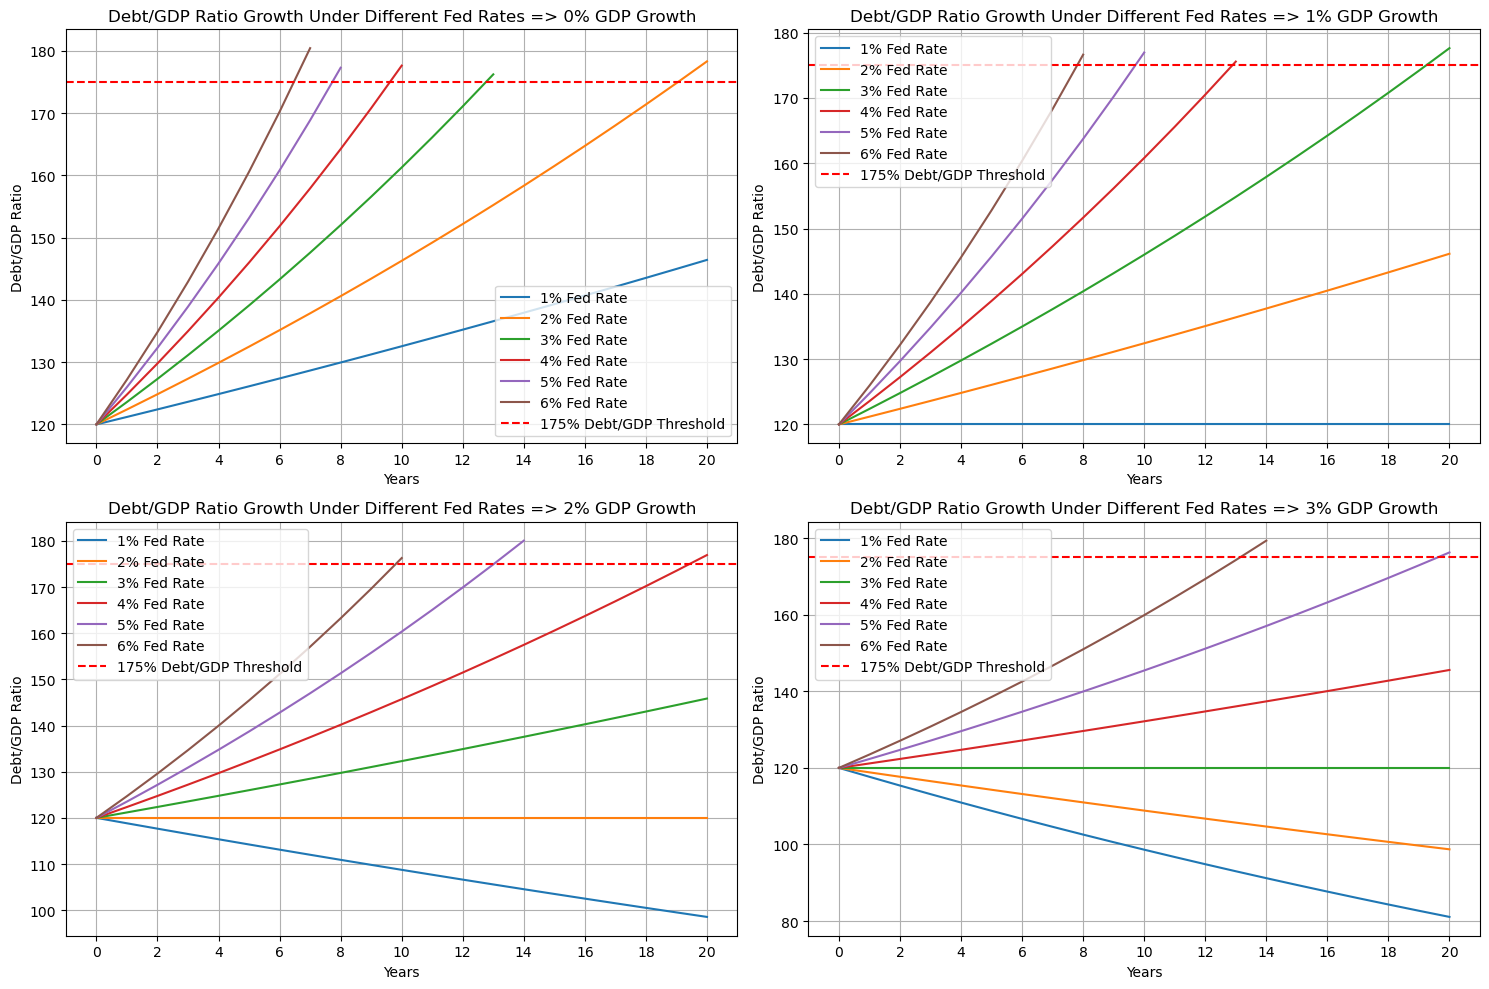

In [71]:
# Load the data.
data = pd.read_csv("data/data.csv")

# Define target debt/GDP ratio.
target_threshold = 175  # 175%

# Define current debt/GDP ratio (as of September 2024).
current_debt_to_gdp = 120  # 120%

# Define different Fed rates to test.
fed_rates = [1, 2, 3, 4, 5, 6]  # Fed rates in percentages.

# Define different annual GDP growth rates.
gdp_growth_rates = [0, 1, 2, 3]  # GDP growth rates in percentages.

# Initialize results.
results = {}

# Loop through each Fed rate.
for fed_rate in fed_rates:
    for gdp_growth_rate in gdp_growth_rates:
        # Initialize variables.
        debt_to_gdp = current_debt_to_gdp  # Start from current debt/GDP ratio.
        years = 0  # Number of years.

        # Simulate debt/GDP ratio growth.
        while debt_to_gdp < target_threshold and years < 20:  # Limit to 20 years.
            # Update debt/GDP ratio considering Fed rate and GDP growth.
            debt_to_gdp = debt_to_gdp * (1 + (fed_rate / 100)) / (1 + (gdp_growth_rate / 100))
            years += 1

        # Store results.
        key = (fed_rate, gdp_growth_rate)
        results[key] = {
            "Years until 175% debt/GDP": years,
            "Final predicted debt/GDP ratio": debt_to_gdp
        }

# Print results.
for (rate, growth), result in results.items():
    print(f"At {rate}% Fed Rate and {growth}% GDP Growth:")
    if result['Final predicted debt/GDP ratio'] >= 175:
        print(f"Years until 175% debt/GDP: {result['Years until 175% debt/GDP']}")
    print(f"Final predicted debt/GDP ratio: {result['Final predicted debt/GDP ratio']:.2f}")
    print("-" * 42)

# Data visualization.
plt.figure(figsize=(15, 10))

for i, gdp_growth_rate in enumerate(gdp_growth_rates):
    plt.subplot(2, 2, i + 1)
    for fed_rate in fed_rates:
        debt_to_gdp = current_debt_to_gdp  # Start from current debt/GDP ratio.
        years_list = [0]  # List of years starting from 0.
        debt_to_gdp_list = [debt_to_gdp]  # List with initial debt/GDP ratio.
        years = 0

        while debt_to_gdp < target_threshold and years < 20:
            debt_to_gdp = debt_to_gdp * (1 + (fed_rate / 100)) / (1 + (gdp_growth_rate / 100))
            years_list.append(years + 1)  # Add next year.
            debt_to_gdp_list.append(debt_to_gdp)  # Add new debt/GDP ratio.
            years += 1

        plt.plot(years_list, debt_to_gdp_list, label=f"{fed_rate}% Fed Rate")

    plt.axhline(y=target_threshold, color="red", linestyle="--", label="175% Debt/GDP Threshold")
    plt.xlabel("Years")
    plt.ylabel("Debt/GDP Ratio")
    plt.title(f"Debt/GDP Ratio Growth Under Different Fed Rates => {gdp_growth_rate}% GDP Growth")
    plt.legend()
    plt.xticks(range(0, 21, 2))  # Show years from 0 to 20 in steps of 2.
    plt.grid()

plt.tight_layout()
plt.show()

### 5. **Conclusions**

1. In this study, we compiled an economic health indicator from multiple indicators provided by the U.S. economy. And only **<a style="color:purple;">after we ran the features measured in dollars through a deflator did the true state of the U.S. economy become apparent</a>** - the past, the present, and a little bit of the future.
2. The **second** Deep Learning **model predicts** for the near future (9 months ahead). The state of the **economy will be at almost the same level** as the current one.
3. The **latest** Deep Learning **model predicts** the future **Debt/GDP ratio**, but for 2 years ahead. The model does not predict any particular change other than the current state.
4. Using **econometrics**, we saw that the US economy and debt will continue to grow, but their **ratio will change slightly** in the direction of greater indebtedness. From the graph of the **Debt-to-Tax ratio**, we see that the debt exceeds taxes collected by over **11 times** (1125%). Now and in the near future. Such debt is extremely difficult to repay, even in some distant future. We do not even mention the interest on it.
5. The last 4 graphs show the following:
 - This is of course, **if interest rates and GDP growth follow some stable average movement** around the indicated percentages.
 - If the economy had **0% growth**, the debt-to-GDP ratio would reach 175% at a **6% interest** rate in just **over 6 years**, and at a **2% interest** rate in **about 19 years**.
 - If the economy has **1% growth**, the debt/GDP ratio would reach 175% at **6% interest** in **about 8 years**, and at **3% interest** in **about 19 years**.
 - f the economy has **2% growth**, the debt/GDP ratio would reach 175% at **6% interest** in **about 10 years**, and at **4% interest** in **over 19 years**.
 - If the economy has **3% growth**, the debt/GDP ratio would reach 175% at **6% interest** in **about 13 years**, and at **5% interest** in **about 20 years**.
6. Therefore, for the **<a style="color:purple;">US economy to escape bankruptcy over a 20-year period, it must maintain low interest rates (up to 4%) and at least 2% economic growth</a>**. Because the geopolitical situation is unlikely to improve during this period.
7. But from the first and second parts of this study, we saw that US industrial production has currently reached its ceiling. The burden of interest rates is becoming greater and in order to compensate for this (i.e., to have economic growth), the service economy must grow at a very high rate. How this happens, given that the real economy is not growing - I do not know. However, US President Donald Trump knows: first trade wars, then we will see...
8. Some of the data was obtained from a future approximation. The exact historical data will be out in about 3 months. If we want to be perfect - we have to run the models with the latest data. Thanks for your attention :)

### Resources:
1. **Sustainable Economic Indicators**: https://www.sustainable-environment.org.uk/Indicators/Economy.php
2. **GROSS DOMESTIC PRODUCT (GDP)**: https://fred.stlouisfed.org/series/GDP
3. **Consumer Price Index (CPI)**: https://fred.stlouisfed.org/series/CPIAUCSL
4. **Production Index (INDPRO)**: https://fred.stlouisfed.org/series/INDPRO
5. **S&P 500 Index**: https://stooq.com/q/d/?s=%5Espx&c=0&d1=19620101&d2=20241001&i=m
6. **Total Nonfarm Payroll (PAYEMS)**: https://fred.stlouisfed.org/series/PAYEMS
7. **UNEMPLOYMENT (UNRATE)**: https://fred.stlouisfed.org/series/UNRATE
8. **Federal Funds Effective Rate (FEDFUNDS)**: https://fred.stlouisfed.org/series/FEDFUNDS
9. **Total Public Debt (GFDEBTN)**: https://fred.stlouisfed.org/series/GFDEBTN
10. **Personal Saving Rate (PSAVERT)**: https://fred.stlouisfed.org/graph/?g=580A
11. **Real GDP per capita (A939RX0Q048SBEA)**: https://fred.stlouisfed.org/series/A939RX0Q048SBEA
12. **Total Public Debt as Percent of GDP (GFDEGDQ188S)**: https://fred.stlouisfed.org/series/GFDEGDQ188S
13. **Trade Balance (BOPGSTB)**: https://fred.stlouisfed.org/series/BOPGSTB
14. **United States Balance of Trade**: https://tradingeconomics.com/united-states/balance-of-trade
15. **Energy goods and services (DNRGRC1M027SBEA)**: https://fred.stlouisfed.org/series/DNRGRC1M027SBEA
16. **Interest payments (A091RC1Q027SBEA)**: https://fred.stlouisfed.org/series/A091RC1Q027SBEA
17. **Current tax receipts (W006RC1Q027SBEA)**: https://fred.stlouisfed.org/series/W006RC1Q027SBEA
18. **Slope of the yield curve (T10YFF)**: https://fred.stlouisfed.org/series/T10YFF
19. **Federal Government: Current Expenditures (FGEXPND)**: https://fred.stlouisfed.org/series/FGEXPND
20. **Purchasing Power of the Consumer Dollar in U.S. (CUUR0000SA0R)**: https://fred.stlouisfed.org/series/CUUR0000SA0R
21. **Bloomberg: US stuck in debt denial** https://opposition.bg/bloomberg-sasht-zamryaha-v-sastoyanie-na-otritsanie-na-dalga/